# Exploration of Movie dataset

<a id='table'></a>
## Table of Contents
<ul>
<li><a href="#univariate">Univariate exploration</a></li>
<li><a href="#multivariate">Multivariate exploration</a></li>
<li><a href="#feature_engineering">Feature Engineering</a></li>
<li><a href="#feature_selection">Feature selection</a></li>
<li><a href="#cat_encoding">Encoding categorical variables</a></li>
<li><a href="#dim_reduction">Dimension Reduction: PCA</a></li>
<li><a href="#dim_reduction_tSNE">Dimension Reduction: t-SNE</a></li>
<li><a href="#similarities">Similarities within one cluster</a></li>
<li><a href="#recommendations">Get the movie recommendations</a></li>
<li><a href="#performance">Performance analysis</a></li>
</ul>



## Loading dataset

In [1]:
# starting by import the required libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as st
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
df_movies_clean = pd.read_csv('df_movies_clean.csv', sep=",", encoding='utf_8', low_memory=False)

In [3]:
df_movies_clean.shape

(3733, 29)

In [4]:
# Visual test of import
df_movies_clean.sample(1)

,movie_title,genres,director_name,actor_1_name,actor_2_name,actor_3_name,country,language,color,plot_keywords,...,num_critic_for_reviews,movie_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,genres_col1,revenue,likes_check
3311,D.E.B.S.,Action|Comedy|Romance,Angela Robinson,Jordana Brewster,Geoff Stults,Scoot McNairy,USA,English,Color,"['1959 cadillac', 'diamonds', 'female villain'...",...,50,1000,23,4000,756,660,6380,action,-3403207,941


In [5]:
df_movies_clean.content_rating.value_counts()

R        1784
PG-13    1280
PG        563
G          91
NC-17      15
Name: content_rating, dtype: int64

In [6]:
# Converting content_rating in an ordered categorical variable 
rating = ['G','PG','PG-13','R','NC-17']
ordered_rating = pd.api.types.CategoricalDtype(ordered = True,categories = rating)
df_movies_clean['content_rating'] = df_movies_clean['content_rating'].astype(ordered_rating)

<a id='univariate'></a>
## Univariate Exploration

In [7]:
print(df_movies_clean.columns.values.tolist())

['movie_title', 'genres', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'country', 'language', 'color', 'plot_keywords', 'title_year', 'budget', 'gross', 'duration', 'movie_imdb_link', 'imdb_score', 'content_rating', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'movie_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'cast_total_facebook_likes', 'genres_col1', 'revenue', 'likes_check']


In [8]:
base_color = sb.color_palette()[0]

### What can we observe with the distribution of "title_year"?

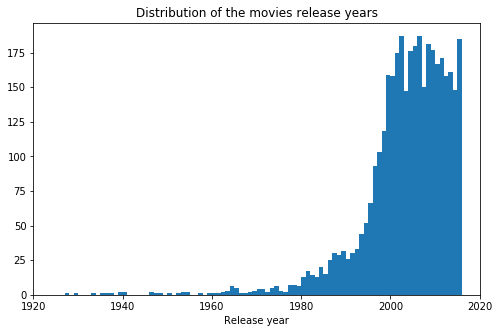

In [9]:
plt.figure(figsize = [8,5])
binsize = 1
bins = np.arange(0, df_movies_clean['title_year'].max()+binsize, binsize)
plt.hist(data = df_movies_clean, x = 'title_year', bins = bins)
plt.xlim([1920,2020])
plt.xlabel('Release year')
plt.title('Distribution of the movies release years');

In [10]:
df_movies_clean['title_year'].describe()

count    3733.000000
mean     2002.984731
std         9.937723
min      1927.000000
25%      1999.000000
50%      2004.000000
75%      2010.000000
max      2016.000000
Name: title_year, dtype: float64

##### Comments:
> We observe that 75% of the movies of this dataset were produced after 1999 (knowing that the dataset starts from 1927 till 2016)


### What is the distribution of the duration ?

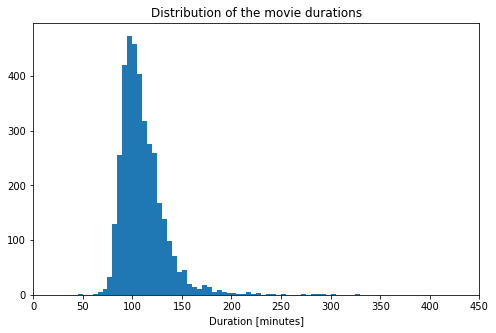

In [11]:
plt.figure(figsize = [8,5])
binsize = 5
bins = np.arange(0, df_movies_clean['duration'].max()+binsize, binsize)
plt.hist(data = df_movies_clean, x = 'duration', bins = bins)
plt.xlim([0,450])
plt.xlabel('Duration [minutes]')
plt.title('Distribution of the movie durations');

In [12]:
df_movies_clean['duration'].describe()

count    3733.000000
mean      109.945084
std        22.594815
min        45.000000
25%        95.000000
50%       106.000000
75%       120.000000
max       330.000000
Name: duration, dtype: float64

In [13]:
df_movies_clean.query('duration == 330')['movie_title']

1404    Blood In, Blood Out
Name: movie_title, dtype: object

##### Comments:
> 75% of the movies last less than 120 minutes. We see that one movie lasts 330 min (5h30 : "Blood in, Blood out")

### Which content_rating classes are most represented ?

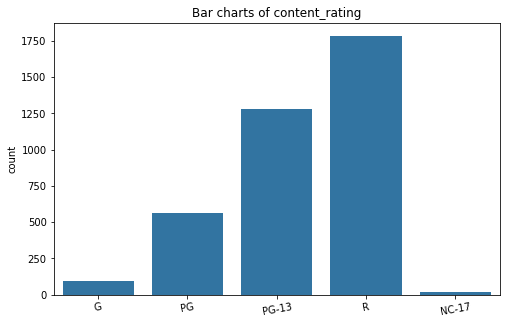

In [14]:
plt.figure(figsize = [8,5])
sb.countplot(data=df_movies_clean,x='content_rating',color=base_color)
plt.xticks(rotation=10)
plt.xlabel('')
plt.title('Bar charts of content_rating');

> - Rated G: All Ages Admitted – General Audiences
> - Rated PG: All Ages Admitted – Parental Guidance Suggested 
> - Rated R: Restricted – Under 17 requires accompanying parent or adult guardian
> - PG-13: Parents Are Strongly Cautioned to Give Special Guidance for Attendance of Children Under 13 
> - NC-17: No one under 17 admitted

##### Comments:
> Most movies are rated R and then movies rated PG-13 are the second most represented

### What is the budget distribution like ?

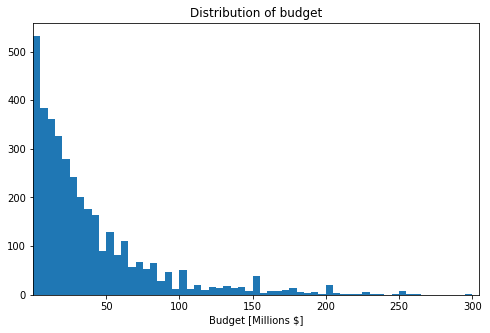

In [15]:
plt.figure(figsize = [8,5])
binsize = 5000000
bins = np.arange(0, df_movies_clean['budget'].max()+binsize, binsize)
plt.hist(data = df_movies_clean, x = 'budget', bins = bins)
ticks = [50000000,100000000,150000000,200000000,250000000,300000000]
labels = ['50','100','150','200','250','300']
plt.xticks(ticks,labels)
plt.xlim([0,df_movies_clean['budget'].max()+binsize,])
plt.xlabel('Budget [Millions $]')
plt.title('Distribution of budget');

In [16]:
df_movies_clean.budget.describe()

count    3.733000e+03
mean     3.738196e+07
std      4.192096e+07
min      2.180000e+02
25%      1.000000e+07
50%      2.400000e+07
75%      5.000000e+07
max      3.000000e+08
Name: budget, dtype: float64

In [17]:
df_movies_clean.query('budget > 250000000')[['movie_title','budget','country']].sort_values(by=['budget'],\
                                                                                            ascending=False)

,movie_title,budget,country
1,Pirates of the Caribbean: At World's End,300000000,USA
4,John Carter,263700000,USA
6,Tangled,260000000,USA
5,Spider-Man 3,258000000,USA


In [18]:
df_movies_clean.query('budget < 5000')[['movie_title','budget','country']].sort_values(by=['budget'])
                                                                                            

,movie_title,budget,country
3652,Tarnation,218,USA
3732,My Date with Drew,1100,USA


##### Comments:
> - 50% of the movies have a budget lower than 24million USD and 75% below 50million USD.
> - Right skewed distribution
> - Biggest budget is for "Pirates of the Caribbean: At Worlds's End", with 300 Mdollars
> - Interesting to see that there are some movies in the ranking with a budget less than 2000 dollars

### What is the gross distribution like?

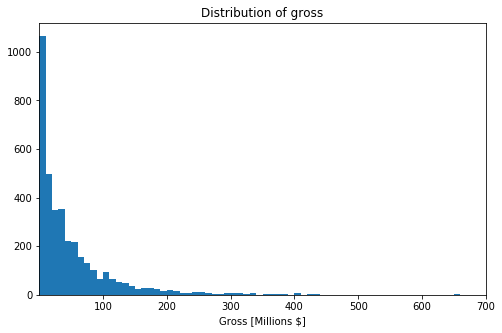

In [19]:
plt.figure(figsize = [8,5])
binsize = 10000000
bins = np.arange(0, df_movies_clean['gross'].max()+binsize, binsize)
plt.hist(data = df_movies_clean, x = 'gross', bins = bins)
ticks = [100000000,200000000,300000000,400000000,500000000,600000000,700000000]
labels = ['100','200','300','400','500','600','700']
plt.xticks(ticks,labels)
plt.xlim([0,700000000])
plt.xlabel('Gross [Millions $]')
plt.title('Distribution of gross');

In [20]:
df_movies_clean.gross.describe()

count    3.733000e+03
mean     5.092484e+07
std      6.897250e+07
min      1.620000e+02
25%      7.156725e+06
50%      2.803125e+07
75%      6.553507e+07
max      7.605058e+08
Name: gross, dtype: float64

In [21]:
df_movies_clean.query('gross > 600000000')[['movie_title','gross','director_name']]\
          .sort_values(by=['gross'],ascending=False)

,movie_title,gross,director_name
0,Avatar,760505847,James Cameron
25,Titanic,658672302,James Cameron
28,Jurassic World,652177271,Colin Trevorrow
16,The Avengers,623279547,Joss Whedon


##### Comments:
> - 75% of the movies have a gross lower than 65million USD
> - Looking at the mean (50,9 million USD) and at the Standard deviation(68,9 million USD), we observe a huge 
variability
> - Right skewed distribution
> - The two movies with biggest gross are "Avatar" and "Titanic" both from James Cameron.

### Are there still a lot "Black and White" movies ?

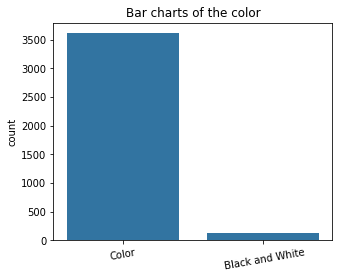

In [22]:
plt.figure(figsize = [5,4])
sb.countplot(data=df_movies_clean,x='color',color=base_color)
plt.xticks(rotation=10)
plt.xlabel('')
plt.title('Bar charts of the color');

In [23]:
# Proportion of movies in color
(df_movies_clean.query('color == "Color"').color.count()/df_movies_clean.shape[0])*100

96.73185105813019

##### Comments:
> Without surprise we see that over 96% of the movies are in color.

### Which countries produce most movies ?

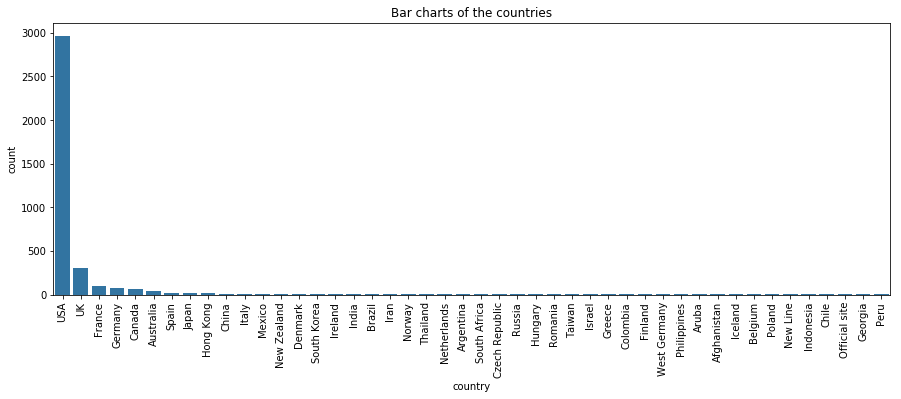

In [24]:
plt.figure(figsize = [15,5])
sb.countplot(data=df_movies_clean,x='country',order=df_movies_clean.country.value_counts().index,
            color=base_color)
plt.xticks(rotation=90)
plt.title('Bar charts of the countries');

In [25]:
# Proportions of 5 most represented countries
(df_movies_clean.country.value_counts().head(5)/df_movies_clean.shape[0])*100

USA        79.480311
UK          8.277525
France      2.759175
Germany     2.062684
Canada      1.660863
Name: country, dtype: float64

##### Comments:
> It's amazing to notice that USA leads with almost 80% of the produced movies. The second country UK has only round 8% and then we have France with less than 3%.

### Are most movies in English ?

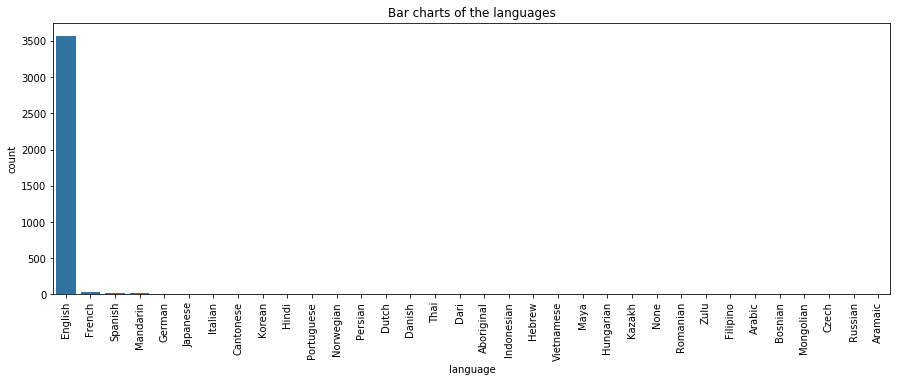

In [26]:
plt.figure(figsize = [15,5])
sb.countplot(data=df_movies_clean,x='language',order=df_movies_clean.language.value_counts().index,
            color=base_color)
plt.xticks(rotation=90)
plt.title('Bar charts of the languages');

In [27]:
# Proportions of 5 most represented languages
(df_movies_clean.language.value_counts().head(5)/df_movies_clean.shape[0])*100

English     95.713903
French       0.910796
Spanish      0.642915
Mandarin     0.375033
German       0.294669
Name: language, dtype: float64

##### Comments:
> Yes definitly, with over 95% of the movies in English.

### How does the IMDB score distribution looks like?

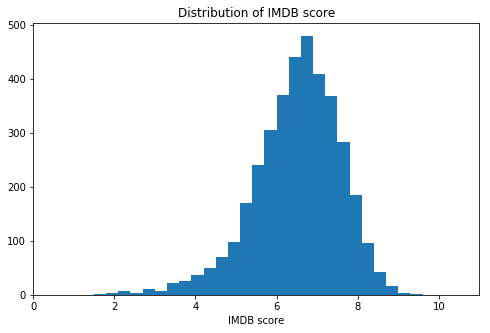

In [28]:
plt.figure(figsize = [8,5])
binsize = 0.3
bins = np.arange(0, df_movies_clean['imdb_score'].max()+binsize, binsize)
plt.hist(data = df_movies_clean, x = 'imdb_score', bins = bins)
plt.xlim([0,11])
plt.xlabel('IMDB score')
plt.title('Distribution of IMDB score');

In [29]:
df_movies_clean.imdb_score.describe()

count    3733.000000
mean        6.458184
std         1.059118
min         1.600000
25%         5.900000
50%         6.600000
75%         7.200000
max         9.300000
Name: imdb_score, dtype: float64

In [30]:
df_movies_clean.query('imdb_score ==9.3')[['movie_title','imdb_score']]

,movie_title,imdb_score
1789,The Shawshank Redemption,9.3


##### Comments:
> - 50% of the movies have less than 6.6 and the mean is 6.45 (symetrical distribution)
> - 25% of the movies have more than 7.2
> - max imdb_score = 9.3 for the "Shawshank Redemption"

<a id='multivariate'></a>
## Multivariate Exploration
<a href="#table">back to content table</a>

### Which are the 15 movies with the highest revenues ?

In [31]:
# Sorting the movies by decreasing revenue and selection the 15 first ones
top15_rev = df_movies_clean.sort_values(by=['revenue'],ascending=False)

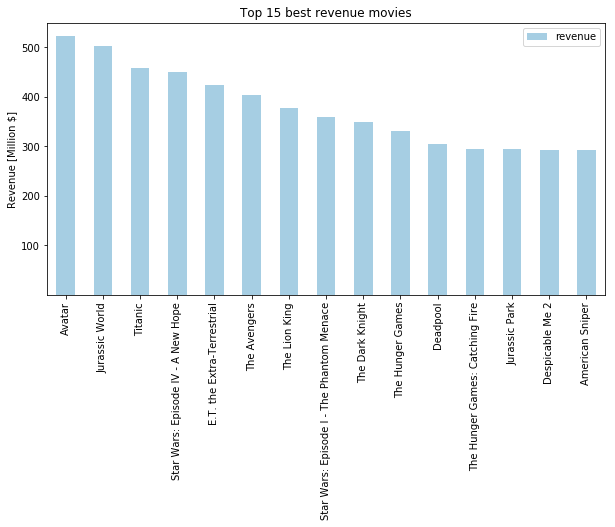

In [32]:
top15_rev.iloc[0:15,:].plot(x='movie_title', y='revenue', kind='bar', colormap='Paired',figsize=(10,5));
plt.title('Top 15 best revenue movies')
plt.xticks(rotation = 90)
ticks = [100000000,200000000,300000000,400000000,500000000]
labels = ['100','200','300','400','500']
plt.yticks(ticks,labels)
plt.xlabel("")
plt.ylabel('Revenue [Million $]');


##### Comments:
> - In the top 5 we find : "Avatar", "Jurassic World", "Titanic", "Star Wars: Episode IV" and "E.T.".
> - Wouldn't it be interesting to see how those 15 movies relate to their "Budget"?

#### What's the relation with the budget ?

In [33]:
movies15 = top15_rev.iloc[0:15,:].movie_title

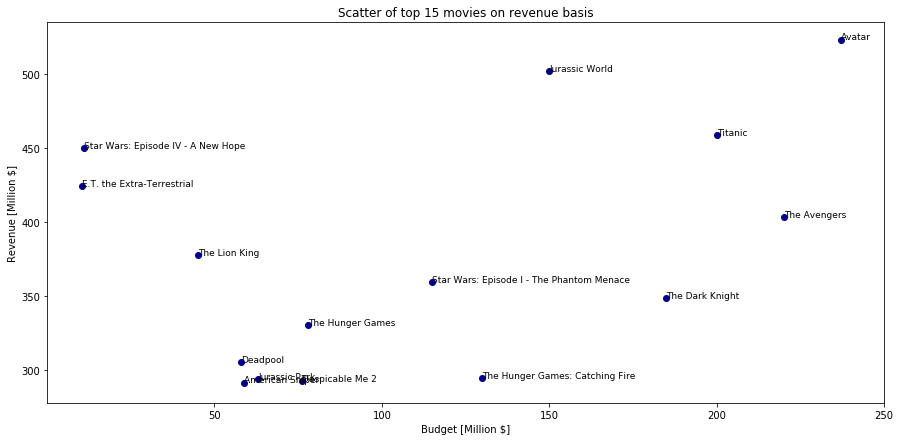

In [34]:
plt.figure(figsize = [15,7])

for i,movie_title in enumerate(movies15):
    x = top15_rev.budget.iloc[i]
    y = top15_rev.revenue.iloc[i]
    plt.scatter(x,y,color='darkblue')
    plt.text(x+1, y+1, movie_title, fontsize=9)
ticks_x = [50000000,100000000,150000000,200000000,250000000]
labels_x = ['50','100','150','200','250']
plt.xlim([0,250000000])
plt.xticks(ticks_x,labels_x)
ticks_y = [300000000,350000000,400000000,450000000,500000000]
labels_y = ['300','350','400','450','500']
plt.yticks(ticks_y,labels_y)
plt.title("Scatter of top 15 movies on revenue basis")
plt.xlabel('Budget [Million $]')
plt.ylabel('Revenue [Million $]')
plt.show();

##### Comments:
> - We see that the first 3 movies, are in the right upper corner, with indeed with highest revenue but ALSO high budget.
> - Where "Star Wars: Episode IV" and "E.T." are in the upper left corner, high revenue but low budget. What's even beter as this reduces the initial risk.

### Which are the 15 movies with the highest IMDB scores?

In [35]:
# Sorting the movies by decreasing revenue and selection the 15 first ones
top15_mov_imdb = df_movies_clean.sort_values(by=['imdb_score'],ascending=False)
movies15_imdb = top15_mov_imdb.iloc[0:15,:].movie_title

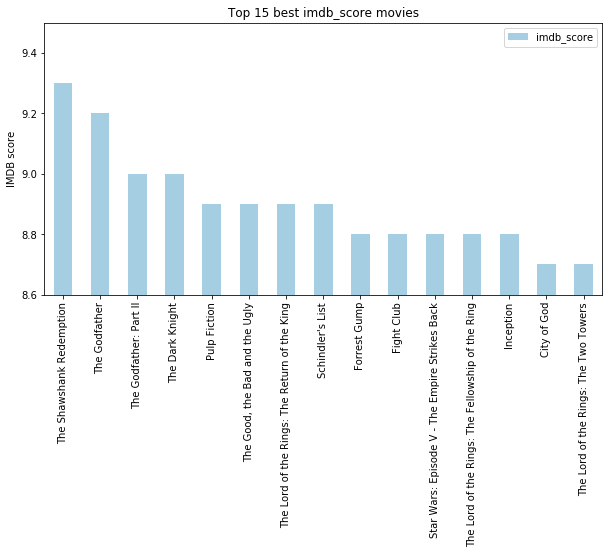

In [36]:
top15_mov_imdb.iloc[0:15,:].plot(x='movie_title', y='imdb_score', kind='bar', colormap='Paired',figsize=(10,5));
plt.title('Top 15 best imdb_score movies')
plt.xticks(rotation = 90)
plt.ylim([8.6,9.5])
plt.xlabel("")
plt.ylabel('IMDB score');

##### Comments:
> - **First observation**: besides "The Dark Knight", we face here with completely other movies than the top 15 highest revenues.
> - Two movies have a score over 9: "The Shawshank Redemption" and "The Godfather"
> - What is here the relation with the revenues?


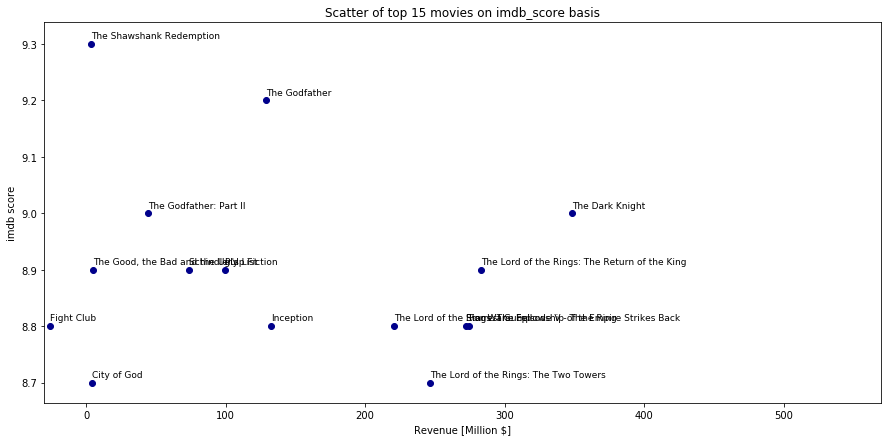

In [37]:
plt.figure(figsize = [15,7])

for i,movie_title in enumerate(movies15_imdb):
    x = top15_mov_imdb.revenue.iloc[i]
    y = top15_mov_imdb.imdb_score.iloc[i]
    plt.scatter(x,y,color='darkblue')
    plt.text(x+0.1, y+0.01, movie_title, fontsize=9)
ticks_x = [0,100000000,200000000,300000000,400000000,500000000]
labels_x = ['0','100','200','300','400','500']
plt.xlim([-30000000,570000000])
plt.xticks(ticks_x,labels_x)
plt.title("Scatter of top 15 movies on imdb_score basis")
plt.xlabel('Revenue [Million $]')
plt.ylabel('imdb score')
plt.show();

### What about the ranking of the 15 directors linked to the average IMDB_score / average revenue?

In [38]:
top_directors_imdb = df_movies_clean.groupby(['director_name']).mean()

In [39]:
top_imdb = top_directors_imdb.sort_values(by=['imdb_score'],ascending=False).iloc[0:15,:]

In [40]:
top_revenue =  top_directors_imdb.sort_values(by=['revenue'],ascending=False).iloc[0:15,:]

#### Best average IMDB score

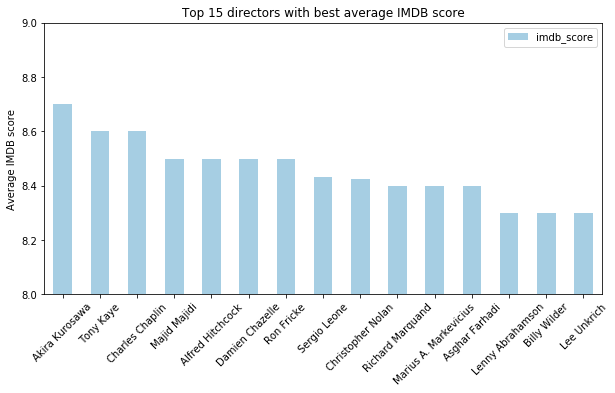

In [41]:
top_imdb.plot( y='imdb_score', kind='bar', colormap='Paired',figsize=(10,5));
plt.title('Top 15 directors with best average IMDB score')
plt.ylim([8,9])
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylabel('Average IMDB score');

#### Comments:
> - if we look at the movies in the dataset for the first 3 directors, we see there's only 1 movie for each.
> - In this case, the average IMDB score, isn't maybe that representative (compared to directors having more than 1 movie in the dataset)
> - So we'll do the same graph but with the maximum IMDB score

In [42]:
df_movies_clean.query('director_name in ["Akira Kurosawa","Tony Kaye","Charles Chaplin"]')[['director_name','movie_title','imdb_score','title_year']]


,director_name,movie_title,imdb_score,title_year
2792,Tony Kaye,American History X,8.6,1998
3494,Charles Chaplin,Modern Times,8.6,1936
3632,Akira Kurosawa,Seven Samurai,8.7,1954


#### Maximum IMDB score

In [43]:
top_directors_imdb_max = df_movies_clean.groupby(['director_name']).max()

In [44]:
max_imdb = top_directors_imdb_max.sort_values(by=['imdb_score'],ascending=False).iloc[0:15,:]

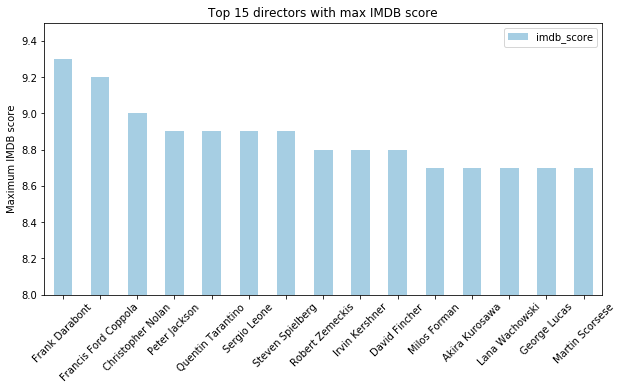

In [45]:
max_imdb.plot( y='imdb_score', kind='bar', colormap='Paired',figsize=(10,5));
plt.title('Top 15 directors with max IMDB score')
plt.ylim([8,9.5])
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylabel('Maximum IMDB score');

#### Best average revenue/movie

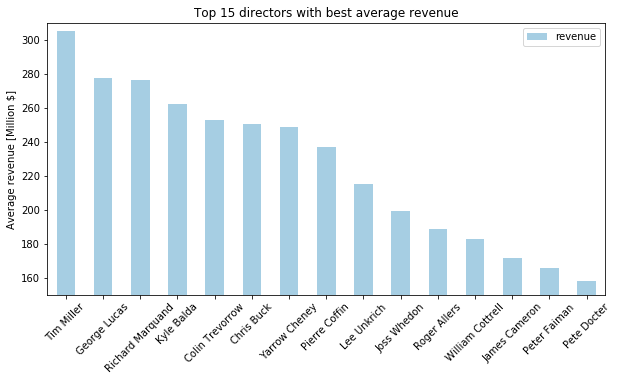

In [46]:
top_revenue.plot( y='revenue', kind='bar', colormap='Paired',figsize=(10,5));
plt.title('Top 15 directors with best average revenue')
plt.ylim([150000000,310000000])
ticks = [160000000,180000000,200000000,220000000,240000000,260000000,280000000,300000000]
labels = ['160','180','200','220','240','260','280','300']
plt.yticks(ticks,labels)
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylabel('Average revenue [Million $]');

### Scatterplots

In [47]:
movie_scatter = ['title_year', 'budget', 'gross', 'duration', 'imdb_score', 'movie_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'cast_total_facebook_likes', 'revenue']

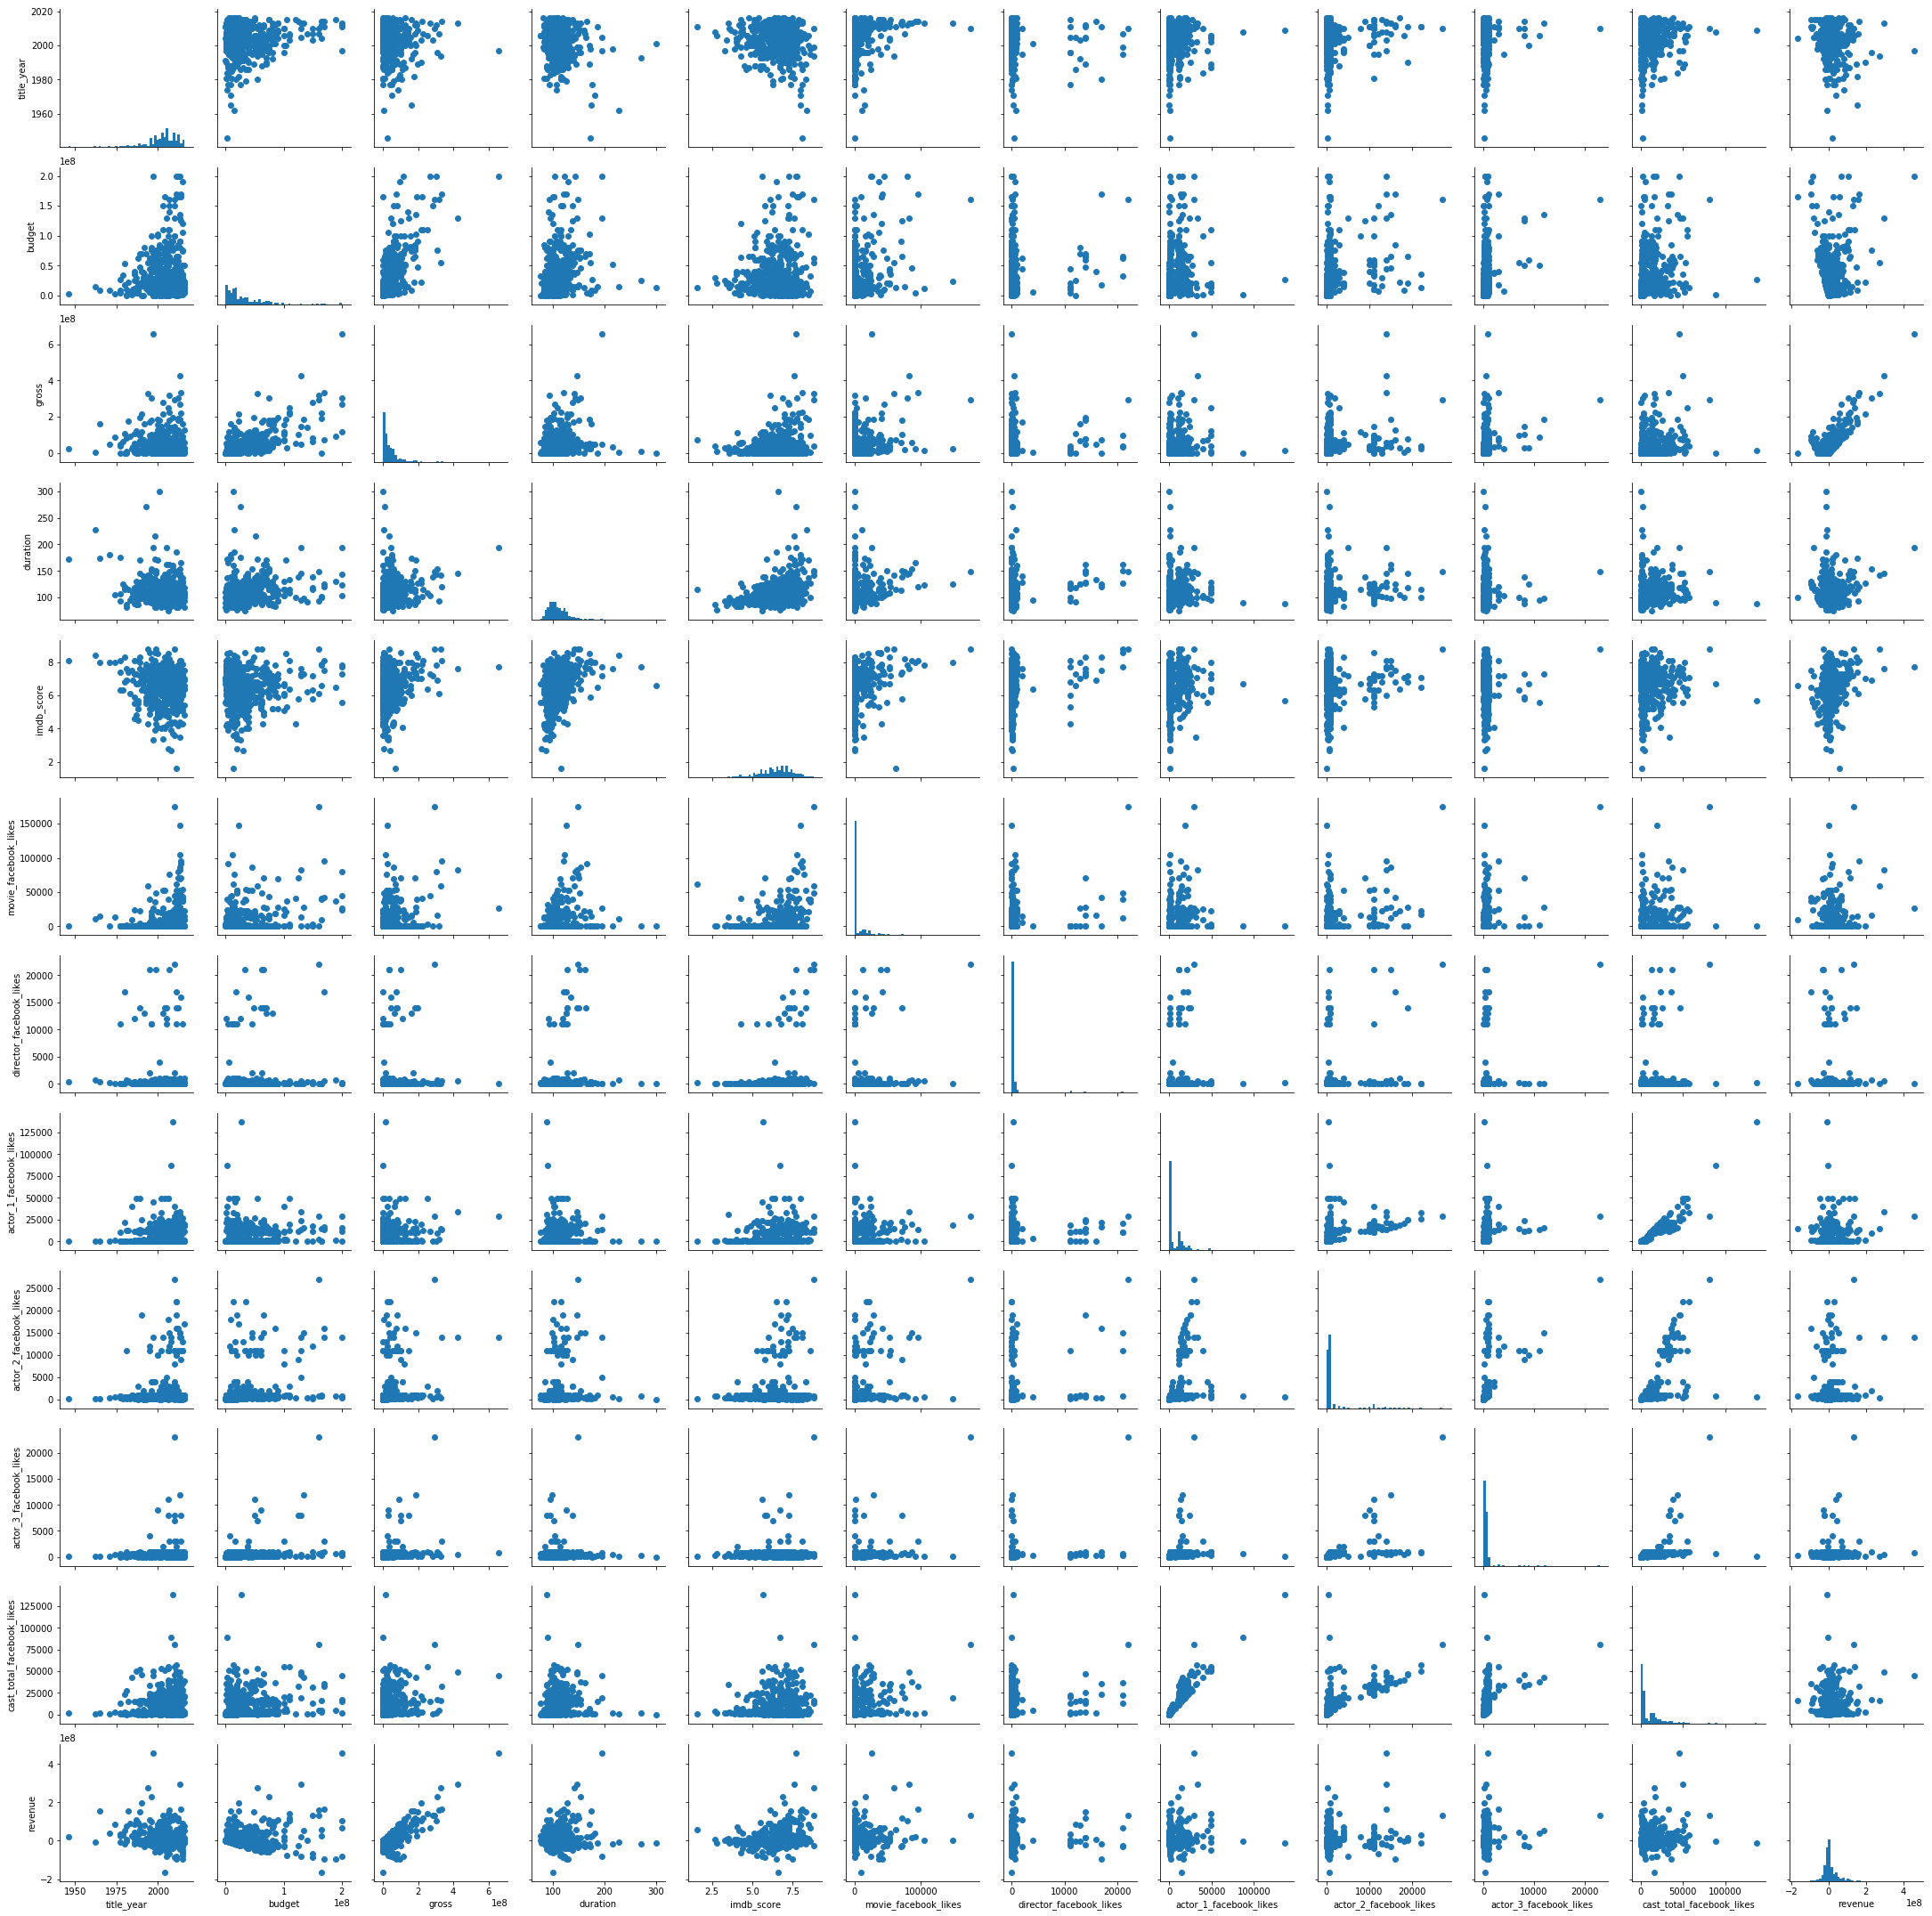

In [48]:
# plot matrix: sample 500 movies so that plots are clearer and
# they render faster
df_samp = df_movies_clean.sample(500)

g = sb.PairGrid(data=df_samp, vars=movie_scatter)
g = g.map_diag(plt.hist,bins=50)
g.map_offdiag(plt.scatter);

In [49]:
print("Pearson coefficient : movie_facebook_likes vs actor_1_facebook_likes")
print(st.pearsonr(df_movies_clean.movie_facebook_likes, df_movies_clean.actor_1_facebook_likes)[0])
print("Pearson coefficient : cast_total_facebook_likes vs actor_1_facebook_likes")
print(st.pearsonr(df_movies_clean.cast_total_facebook_likes, df_movies_clean.actor_1_facebook_likes)[0])
print("Pearson coefficient : movie_facebook_likes vs imdb_score")
print(st.pearsonr(df_movies_clean.movie_facebook_likes, df_movies_clean.imdb_score)[0])
print("Pearson coefficient : imdb_score vs revenue")
print(st.pearsonr(df_movies_clean.imdb_score, df_movies_clean.revenue)[0])
print("Pearson coefficient : budget vs gross")
print(st.pearsonr(df_movies_clean.budget, df_movies_clean.gross)[0])

Pearson coefficient : movie_facebook_likes vs actor_1_facebook_likes
0.12641462967935804
Pearson coefficient : cast_total_facebook_likes vs actor_1_facebook_likes
0.9468257834770718
Pearson coefficient : movie_facebook_likes vs imdb_score
0.28585878080453364
Pearson coefficient : imdb_score vs revenue
0.2559013862678861
Pearson coefficient : budget vs gross
0.6490452955508974


**Comments:**

"cast_total_facebook_likes" is highly correlated with "actor_1_facebook_likes" and we saw that "actor_2_..." and "actor_3..." are less present. So we'll keep only "cast_total_facebook_likes".

<a id='feature_engineering'></a>
## Feature engineering
<a href="#table">back to content table</a>

##### Define

Let's define success as the ratio of revenue/budget 

##### Code

In [50]:
df_movies_clean['success'] = df_movies_clean['revenue']/df_movies_clean['budget']

##### Exploration of new feature

In [51]:
df_movies_clean.success.describe()

count    3733.000000
mean        5.252628
std       132.152716
min        -0.999982
25%        -0.534445
50%         0.083344
75%         1.231752
max      7193.485533
Name: success, dtype: float64

In [52]:
top15_success = df_movies_clean.sort_values(by=['success'],ascending=False)

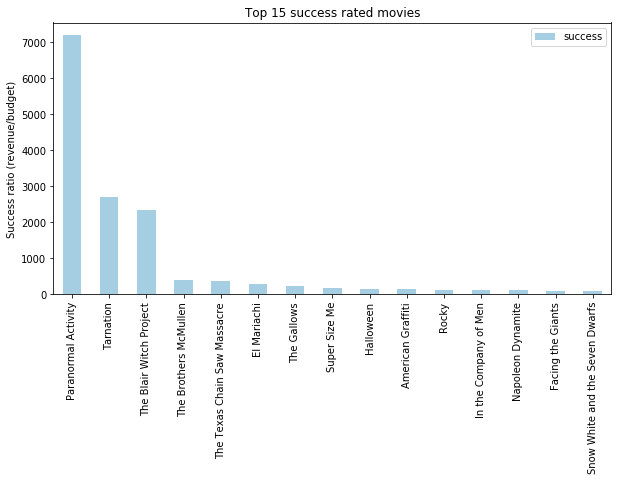

In [53]:
top15_success.iloc[0:15,:].plot(x='movie_title', y='success', kind='bar', colormap='Paired',figsize=(10,5));
plt.title('Top 15 success rated movies')
#plt.ylim([8,9])
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel('Success ratio (revenue/budget)');

#### Comments:
> - We observe that "Paranormal Activity" has from far the best success ratio
> - "Tarnation" and "The Blair Witch project" have also very success ratios

#### Success ratio on Budget - IMDB_score scatter

In [54]:
num_mv  = 10
movies15_success = top15_success.iloc[0:num_mv,:].movie_title

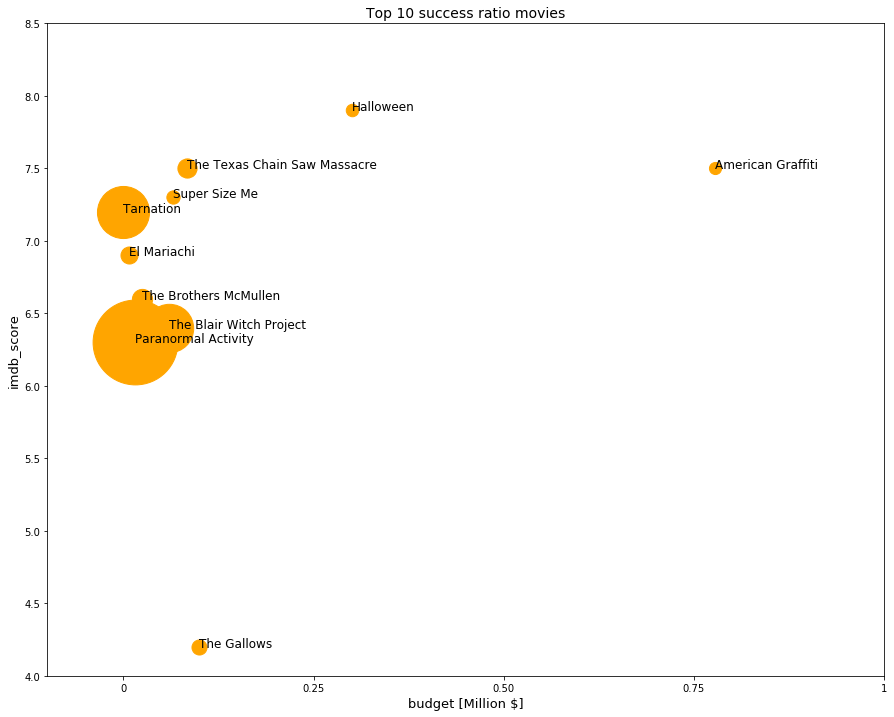

In [55]:
# plotting

plt.figure(figsize = [15,12])
for i,movie_title in enumerate(movies15_success):
    x = top15_success.budget.iloc[i]
    y = top15_success.imdb_score.iloc[i]
    s = top15_success.success.iloc[i]
    plt.scatter(x,y,s,color='orange')
    plt.text(x+1, y, movie_title, fontsize=12)

ticks_x = [0,250000,500000,750000,1000000]
labels_x = ['0','0.25','0.50','0.75','1']
plt.xticks(ticks_x,labels_x)

plt.xlim([-100000,1000000])
plt.ylim([4,8.5])
plt.title(f'Top {num_mv} success ratio movies',fontsize=14)
plt.xlabel('budget [Million $]',fontsize=13)
plt.ylabel('imdb_score',fontsize=13)
plt.show()

<a id='feature_selection'></a>
## Feature selection
<a href="#table">back to content table</a>

### With the univariate exploration in the back of our head

> We won't further use the country nor the language in our study as:
> - almost 80% of the movies are made in the USA (so not so distinctif parameter)
> - more than 95% of the movies are in english

### Correlation Matrix

In [56]:
# Source Chris Alban's page
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# Create correlation matrix
df_corr = ['title_year','budget','gross','duration','imdb_score','num_voted_users','num_user_for_reviews',
          'num_critic_for_reviews', 'movie_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes',
          'actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes','revenue','success']
corr_matrix = df_movies_clean[df_corr].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

['cast_total_facebook_likes']


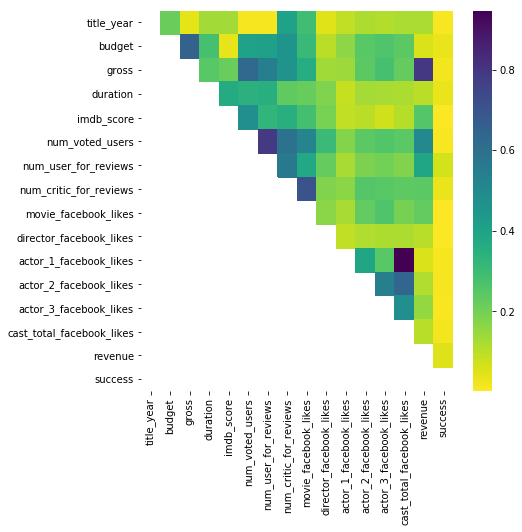

In [57]:
plt.figure(figsize = [7,7])
# plot the heatmap
sb.heatmap(upper, cmap='viridis_r',xticklabels=upper.columns,yticklabels=upper.columns);

#### Comments:
> - we observe logically a correlatin between: "gross" vs "revenue" and "actor_1_facebook_likes" vs "cast_total_facebook_likes" 

<a id='cat_encoding'></a>
## Encoding Categorical Variables
<a href="#table">back to content table</a>

### country

> - As we saw earlier during the exploration, 79.48% of the movies are produced in the US, 8.27% in the UK and the rest of the movies, is divided in small amounts over all the remaining countries.
> - We'll group all the other countries under 'Other'

In [58]:
# if contry not USA or UK => convert to other
df_movies_clean['country'] = df_movies_clean['country'].apply(lambda x: x if (x=='USA' or x=='UK') 
                                                                           else 'Other')

> Here we'll chose one-hot encoding (get_dummies)

##### Code

In [59]:
df_movies_clean[['country_other','country_UK','country_USA']]= pd.get_dummies(df_movies_clean['country'])

##### Test

In [60]:
df_movies_clean[['country','country_other','country_UK','country_USA']].sample(10)

,country,country_other,country_UK,country_USA
1124,USA,0,0,1
629,USA,0,0,1
569,USA,0,0,1
2942,USA,0,0,1
967,USA,0,0,1
3563,USA,0,0,1
495,USA,0,0,1
2357,USA,0,0,1
329,UK,0,1,0
2797,USA,0,0,1


### content_rating

##### Code

In [61]:
df_movies_clean[['rating_G','rating_PG','rating_PG_13','rating_R','rating_NC_17']] = \
                                                        pd.get_dummies(df_movies_clean['content_rating'])

##### Test

In [62]:
df_movies_clean[['content_rating','rating_G','rating_PG','rating_PG_13','rating_R','rating_NC_17']].sample(5)

,content_rating,rating_G,rating_PG,rating_PG_13,rating_R,rating_NC_17
796,PG-13,0,0,1,0,0
993,PG,0,1,0,0,0
1138,R,0,0,0,1,0
3599,R,0,0,0,1,0
109,R,0,0,0,1,0


### genres

##### Code

In [63]:
df_movies_clean[['genre_action', 'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime',
       'genre_documentary', 'genre_drama', 'genre_family', 'genre_fantasy', 'genre_film-noir',
       'genre_history', 'genre_horror', 'genre_music', 'genre_musical', 'genre_mystery', 'genre_romance',
       'genre_sci_fi', 'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']]\
                = df_movies_clean['genres'].str.get_dummies('|')

##### Test

In [64]:
df_movies_clean[['genre_action', 'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime',
       'genre_documentary', 'genre_drama', 'genre_family', 'genre_fantasy', 'genre_film-noir',
       'genre_history', 'genre_horror', 'genre_music', 'genre_musical', 'genre_mystery', 'genre_romance',
       'genre_sci_fi', 'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']].head(5)

,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,genre_fantasy,...,genre_horror,genre_music,genre_musical,genre_mystery,genre_romance,genre_sci_fi,genre_sport,genre_thriller,genre_war,genre_western
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<a id='dim_reduction'></a>
## Dimension Reduction: PCA
<a href="#table">back to content table</a>

In [65]:
movies_PCA_col = ['movie_title', 'budget', 'gross', 'duration', 'imdb_score', 'num_voted_users', 
           'num_user_for_reviews', 'num_critic_for_reviews', 'movie_facebook_likes', 'director_facebook_likes', 
           'actor_1_facebook_likes']

In [66]:
# Only keeping the desired columns
PCA_data_01 = df_movies_clean[movies_PCA_col]
PCA_data_01.set_index('movie_title', inplace=True)

In [67]:
# conversion to a numpy array
X = PCA_data_01.values
X.shape

(3733, 10)

##### Standarizing the data (pre-requisite for the PCA)
> As **PCA** is affected by **scale**, we need to scale the features in our data before applying PCA.

In [68]:
# As the different values aren't of the same scale (year,imdb_score, gross,...) => standardiser
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [69]:
# Standardizing the features
X_scaled_01 = StandardScaler().fit_transform(X)

In [70]:
# check of standarizing
print(np.mean(X_scaled_01,axis=0))
# check of standarizing
print(np.std(X_scaled_01,axis=0))

[ 1.21818203e-16  0.00000000e+00  3.04545507e-16 -9.13636521e-17
 -1.52272753e-17 -4.56818260e-17 -3.04545507e-17  0.00000000e+00
  2.28409130e-17  1.52272753e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


##### Applying the PCA to standardized data

In [71]:
# Applying a PCA
from sklearn.decomposition import PCA

In [72]:
# pca with 2 main components
pca = PCA(n_components=2)

In [73]:
# we apply the PCA object to the normalized values
principalComponents = pca.fit_transform(X_scaled_01)

##### Comments:
>The explained variance tells you how much information (variance) can be attributed to each of the principal components. 

In [74]:
print(pca.explained_variance_ratio_)

[0.41363268 0.11858574]


In [75]:
# how much % of variance they explain both together
print(pca.explained_variance_ratio_.cumsum())

[0.41363268 0.53221843]


#### Comments:
> - Here we see that only 53% of the variance is explained by both principal components, which is low (almost half of the information is lost !).
> - To visualize the projection of those points on this 2-D space, we'll sample 100 points to make it more visual.
> And we'll project those initial points on the 2 principal axes.

In [76]:
# taking a sample of 100 points
X_projected_01 = pca.transform(X_scaled_01)
print(X_projected_01.shape)

(3733, 2)


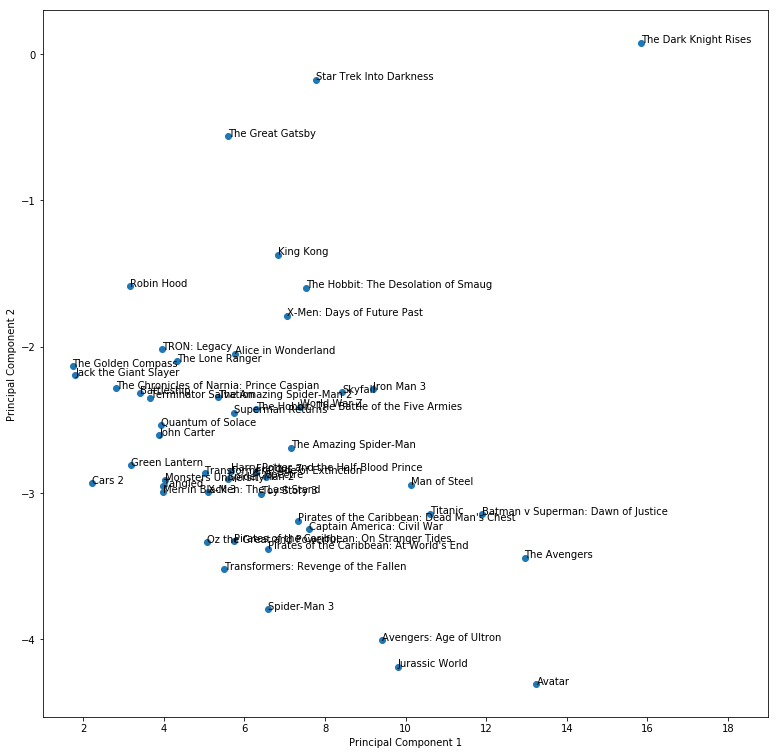

''

In [77]:
# As the values were standardized => we'll force the figure to be squared
fig = plt.figure(figsize=(13,13))
nb_movies = 50
plt.scatter(X_projected_01[:nb_movies,0],X_projected_01[:nb_movies,1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
for i, (x,y) in enumerate(zip(X_projected_01[:nb_movies,0],X_projected_01[:nb_movies,1])):
    plt.text(x,y,PCA_data_01.index[i]) 
    
plt.xlim([1,19])
plt.show()
;

In [78]:
# The coordinates of my Principal components
pcs = pca.components_

Text(0,0.5,'PC2')

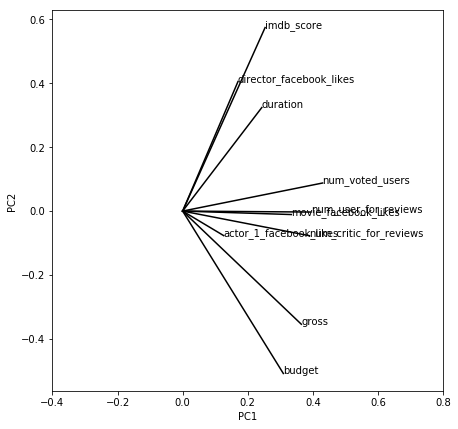

In [79]:
# Display according to those 2 Principal Components the contribution of each inital variable

fig = plt.figure(figsize=(7,7))

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,x],[0,y],color='k')
    plt.text(x,y,PCA_data_01.columns[i])
plt.xlim([-0.4,0.8])
plt.xlabel('PC1')
plt.ylabel('PC2')

### PCA keeping 85% of the variance information

In [80]:
pca_85 = PCA(.85)

In [81]:
# we apply the PCA object to the normalized values
principalComponents_85 = pca_85.fit_transform(X_scaled_01)

In [82]:
print(pca_85.explained_variance_ratio_)

[0.41363268 0.11858574 0.09632641 0.09275687 0.08497336 0.06962618]


In [83]:
# how much % of variance they explain both together
print(pca_85.explained_variance_ratio_.cumsum())

[0.41363268 0.53221843 0.62854484 0.72130171 0.80627508 0.87590126]


In [84]:
# Project data on the principal axis
X_projected_85 = pca_85.transform(X_scaled_01)
print(X_projected_85.shape)

(3733, 6)


#### Comments:
> - We see that with the PCA in this case to reach 85% explanation of variation, we should keep 6 principal components, starting from 11 variables. 
> - Additionnally we have a lot of categorical variables and it isn't advised to apply PCA on those.
> - So here, we'll try to move forward with t-SNE

<a id='dim_reduction_tSNE'></a>
## Dimension Reduction: t-Stochastic Neighbour Embedding
<a href="#table">back to content table</a>

In [85]:
df_tsne = ['movie_title','title_year', 'budget', 'gross', 'duration', 'imdb_score', 'num_voted_users', 
           'num_user_for_reviews', 'num_critic_for_reviews', 'movie_facebook_likes', 'director_facebook_likes', 
           'actor_1_facebook_likes','country_other', 'country_UK', 'country_USA', 'rating_G', 'rating_PG', 
           'rating_PG_13', 'rating_R', 'rating_NC_17','genre_action', 'genre_adventure', 'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime',
       'genre_documentary', 'genre_drama', 'genre_family', 'genre_fantasy', 'genre_film-noir',
       'genre_history', 'genre_horror', 'genre_music', 'genre_musical', 'genre_mystery', 'genre_romance',
       'genre_sci_fi', 'genre_sport', 'genre_thriller', 'genre_war', 'genre_western']

In [86]:
# Additional imports
import matplotlib.pyplot as plt
from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)
from matplotlib import offsetbox

In [87]:
tSNE_data = df_movies_clean[df_tsne]

In [88]:
tSNE_data.shape

(3733, 42)

In [89]:
# Defining the dataset columns as input for the t-SNE algorithm
X_tsne = tSNE_data.iloc[:,1:].values

In [90]:
tSNE_data.head(1)

,movie_title,title_year,budget,gross,duration,imdb_score,num_voted_users,num_user_for_reviews,num_critic_for_reviews,movie_facebook_likes,...,genre_horror,genre_music,genre_musical,genre_mystery,genre_romance,genre_sci_fi,genre_sport,genre_thriller,genre_war,genre_western
0,Avatar,2009,237000000,760505847,178.0,7.9,886204,3054,723,33000,...,0,0,0,0,0,1,0,0,0,0


### Prepa labels for genre in the t-SNE 

In [91]:
# First genre mentionned in collection of genres
first_genre = df_movies_clean['genres_col1'].astype('str')

In [92]:
first_genre.value_counts()

comedy         1008
action          930
drama           666
adventure       363
crime           250
biography       205
horror          156
animation        46
fantasy          35
documentary      34
mystery          22
sci-fi            7
western           3
family            3
musical           2
thriller          2
romance           1
Name: genres_col1, dtype: int64

##### Code

In [93]:
keys = first_genre.value_counts().index
values = [i for i in range(0,first_genre.value_counts().index.shape[0])] # List-comprehension
dico_genres = dict(zip(keys, values))

In [94]:
df_movies_clean['genres_label'] = df_movies_clean['genres_col1'].apply(lambda x: dico_genres[x])

##### Test

In [95]:
df_movies_clean[['movie_title','genres_col1','genres_label']].sample(5)

,movie_title,genres_col1,genres_label
548,Two Brothers,adventure,3
3069,The Wrestler,drama,2
3104,L'auberge espagnole,comedy,0
2752,Swimfan,drama,2
826,The Pirates! Band of Misfits,adventure,3


### Standardizing the features before applying t-SNE

In [96]:
# Standardizing the features
# As the different values aren't of the same scale (year,imdb_score, gross,...) => standardiser
#from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
Xtsne_scaled = StandardScaler().fit_transform(X_tsne)

### t-SNE with different perplexities

#### Perplexity = 5

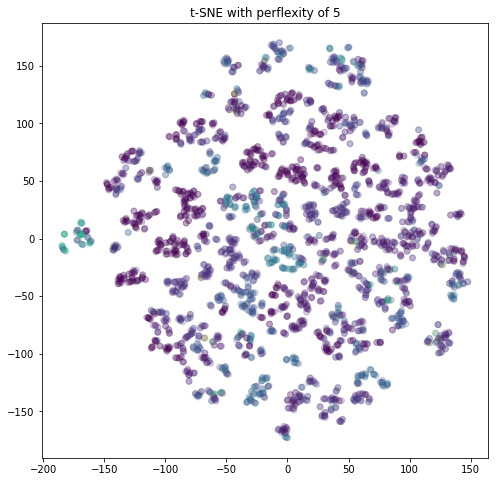

In [97]:
fig = plt.figure(figsize=(8,8))
tsne5 = manifold.TSNE(n_components=2, perplexity=5, n_iter=3000, init='pca')
X_tsne5 = tsne5.fit_transform(Xtsne_scaled)
plot_x5 = X_tsne5[:,0]
plot_y5 = X_tsne5[:,1]
plt.scatter(plot_x5, plot_y5,c=df_movies_clean['genres_label'],alpha=1/5)
plt.title("t-SNE with perflexity of 5")
plt.show()

#### Perplexity = 10

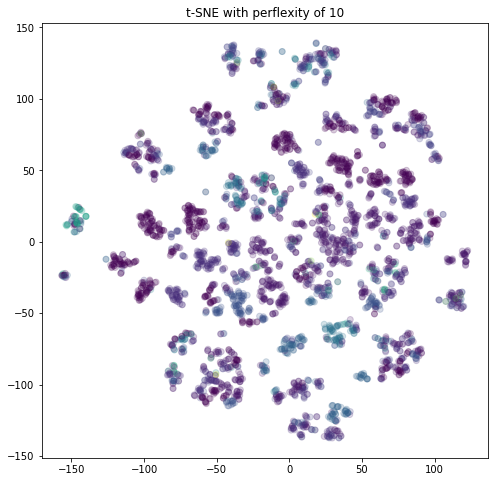

In [98]:
fig = plt.figure(figsize=(8,8))
tsne10 = manifold.TSNE(n_components=2, perplexity=10, n_iter=3000, init='pca')
X_tsne10 = tsne10.fit_transform(Xtsne_scaled)
plot_x10 = X_tsne10[:,0]
plot_y10 = X_tsne10[:,1]
plt.scatter(plot_x10, plot_y10,c=df_movies_clean['genres_label'],alpha=1/5)
plt.title("t-SNE with perflexity of 10")
plt.show()

#### Perplexity = 20

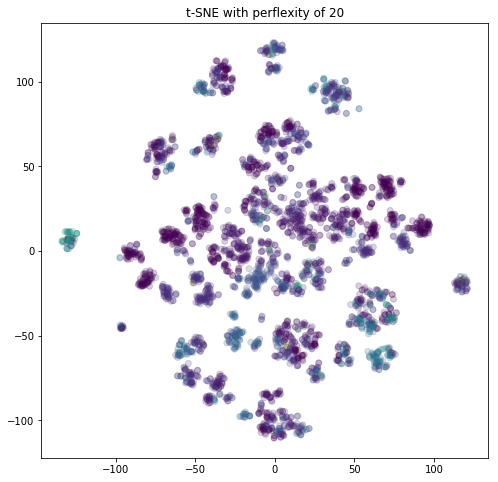

In [97]:
fig = plt.figure(figsize=(8,8))
tsne20 = manifold.TSNE(n_components=2, perplexity=20, n_iter=3000, init='pca')
X_tsne20 = tsne20.fit_transform(Xtsne_scaled)
plot_x20 = X_tsne20[:,0]
plot_y20 = X_tsne20[:,1]
plt.scatter(plot_x20, plot_y20,c=df_movies_clean['genres_label'],alpha=1/5)
plt.title("t-SNE with perflexity of 20")
plt.show()

#### Perplexity = 30

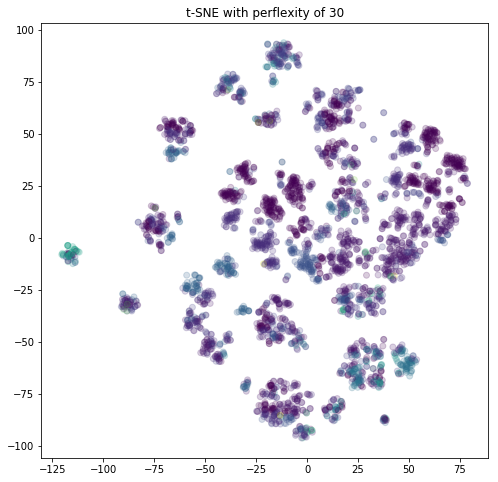

In [100]:
fig = plt.figure(figsize=(8,8))
tsne30 = manifold.TSNE(n_components=2, perplexity=30, n_iter=3000, init='pca')
X_tsne30 = tsne30.fit_transform(Xtsne_scaled)
plot_x30 = X_tsne30[:,0]
plot_y30 = X_tsne30[:,1]
plt.scatter(plot_x30, plot_y30,c=df_movies_clean['genres_label'],alpha=1/5)
plt.title("t-SNE with perflexity of 30")
plt.show()

#### Perplexity = 40

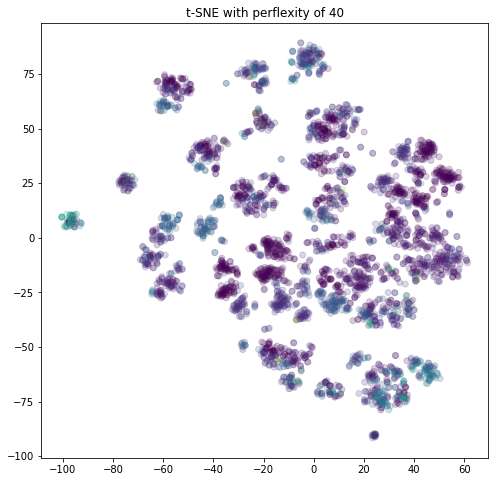

In [101]:
fig = plt.figure(figsize=(8,8))
tsne40 = manifold.TSNE(n_components=2, perplexity=40, n_iter=3000, init='pca')
X_tsne40 = tsne40.fit_transform(Xtsne_scaled)
plot_x40 = X_tsne40[:,0]
plot_y40 = X_tsne40[:,1]
plt.scatter(plot_x40, plot_y40,c=df_movies_clean['genres_label'],alpha=1/5)
plt.title("t-SNE with perflexity of 40")
plt.show()

#### Perplexity = 50

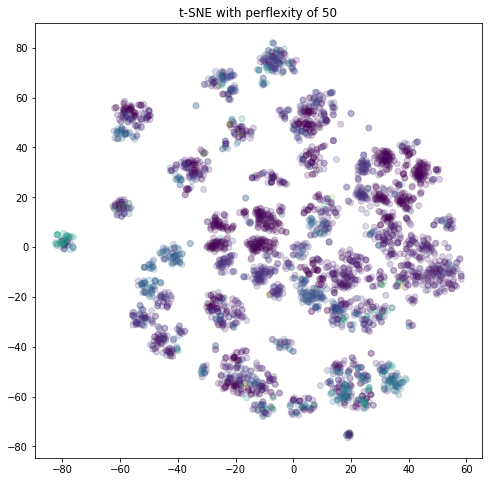

In [102]:
fig = plt.figure(figsize=(8,8))
tsne50 = manifold.TSNE(n_components=2, perplexity=50, n_iter=3000, init='pca')
X_tsne50 = tsne50.fit_transform(Xtsne_scaled)
plot_x50 = X_tsne50[:,0]
plot_y50 = X_tsne50[:,1]
plt.scatter(plot_x50, plot_y50,c=df_movies_clean['genres_label'],alpha=1/5)
#plt.scatter(plot_x50, plot_y50)
plt.title("t-SNE with perflexity of 50")
plt.show()

### Silhouette for different perplexities of t-SNE

> to choose the perplexity value, we'll rely on the one giving the highest maximum silhouette coefficient.

In [103]:
X_TSNE = {'perplexity_5': X_tsne5, 'perplexity_10': X_tsne10, 'perplexity_20':X_tsne20,
         'perplexity_30':X_tsne30, 'perplexity_40':X_tsne40, 'perplexity_50':X_tsne50}

Maximum silhouette for perplexity_5
0.4835603
Maximum silhouette for perplexity_10
0.53684586
Maximum silhouette for perplexity_20
0.55544114
Maximum silhouette for perplexity_30
0.54786515
Maximum silhouette for perplexity_40
0.5247868
Maximum silhouette for perplexity_50
0.52725905


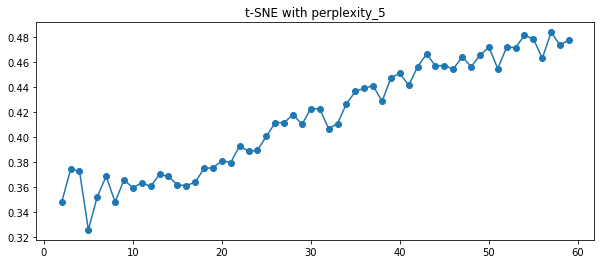

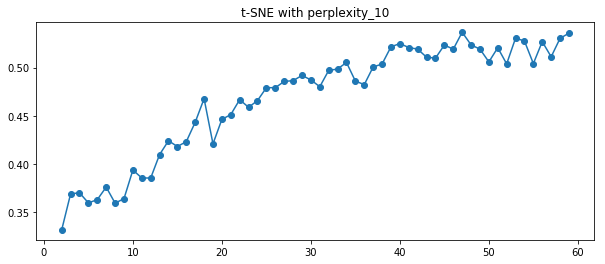

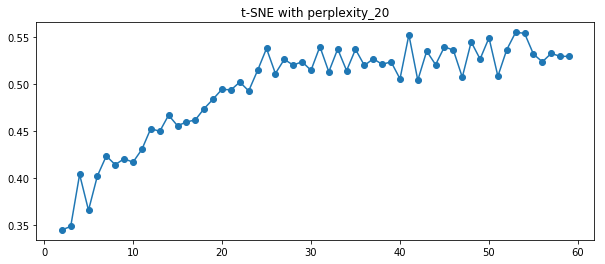

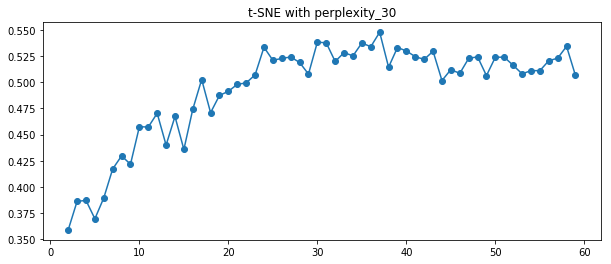

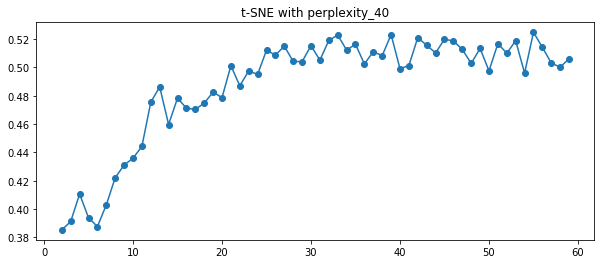

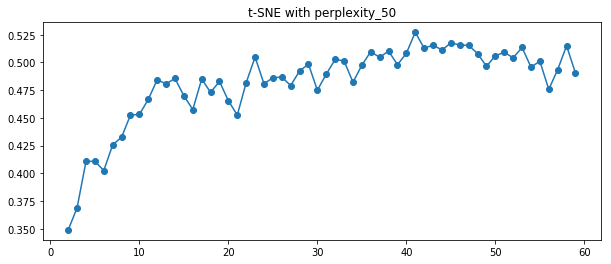

In [104]:
from sklearn import cluster, metrics

#plt.figure(figsize = [20,20])
for perplexity in X_TSNE.keys():
    X_norm = X_TSNE[perplexity]

    fig = plt.figure(figsize=(10,4)) 
    silhouettes = []
    for num_clusters in range(2,60):
        # with unique and randow initialization
        cls = cluster.KMeans(n_clusters = num_clusters,
                        n_init=1,init='k-means++')
        cls.fit(X_norm)
        # computing the shape coefficient
        silh = metrics.silhouette_score(X_norm,cls.labels_)
        silhouettes.append(silh)
    
    print(f'Maximum silhouette for {perplexity}')
    print(max(silhouettes))
    plt.plot(range(2,60),silhouettes, marker='o')
    plt.title(f't-SNE with {perplexity}');

##### Comments:
> -  as perflexity of 20, has maximum silhouette coefficient, we'll choose this perplexity to move forward with the K-means++

<a id='K_means'></a>
## K-means Clustering
<a href="#table">back to content table</a>

> We want to apply the K-means algorithm to the data reduced with t-SNE method

In [98]:
# array with movie titles
movie_title_col = tSNE_data.movie_title.values

In [99]:
# data => TSNE with perplexity of 20, chosen with the comparison of the silhouette coefficients
Xk = X_tsne20
Yk = movie_title_col

In [100]:
# Data already standardized in the t-SNE so:
X_norm = Xk

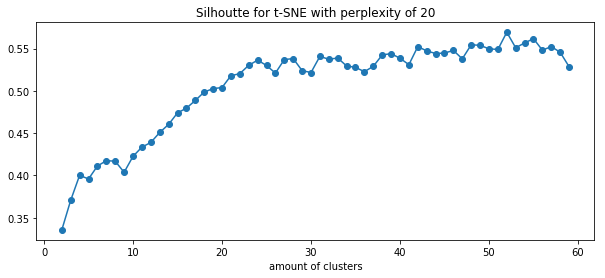

In [101]:
fig = plt.figure(figsize=(10,4))
from sklearn import cluster, metrics
silhouettes = []
for num_clusters in range(2,60):
    # with unique and randow initialization
    cls = cluster.KMeans(n_clusters = num_clusters,
                        init='k-means++')
    cls.fit(X_norm)
    # computing the shape coefficient
    silh = metrics.silhouette_score(X_norm,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(2,60),silhouettes, marker='o')
plt.title('Silhoutte for t-SNE with perplexity of 20')
plt.xlabel('amount of clusters');

> Looking at the graphe of the silhoute, we'll try 34, 51 and 55 clusters

#### Number of clusters : 34

In [102]:
kmeans = cluster.KMeans(n_clusters=34,init='k-means++')
kmeans.fit(X_norm);

In [103]:
X_labels = kmeans.labels_
X_labels.shape

(3733,)

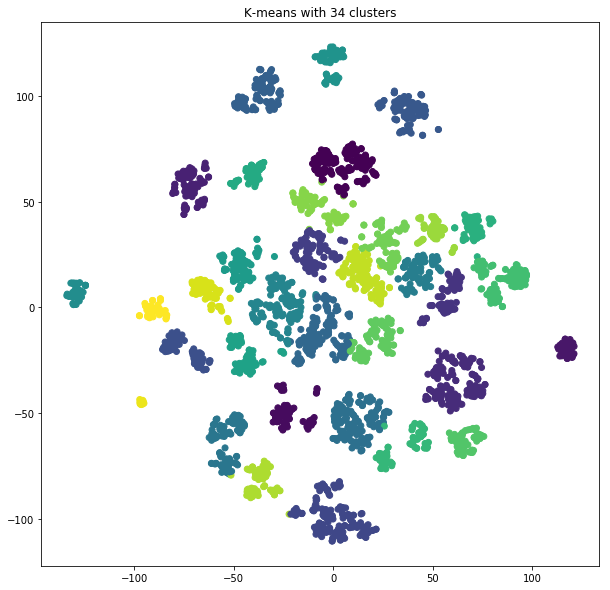

In [104]:
fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_labels)
plt.title("K-means with 34 clusters");

#### Number of clusters: 51

In [105]:
kmeans_51 = cluster.KMeans(n_clusters=51,init='k-means++')
kmeans_51.fit(X_norm);

In [106]:
X_labels_51 = kmeans_51.labels_
X_labels_51.shape

(3733,)

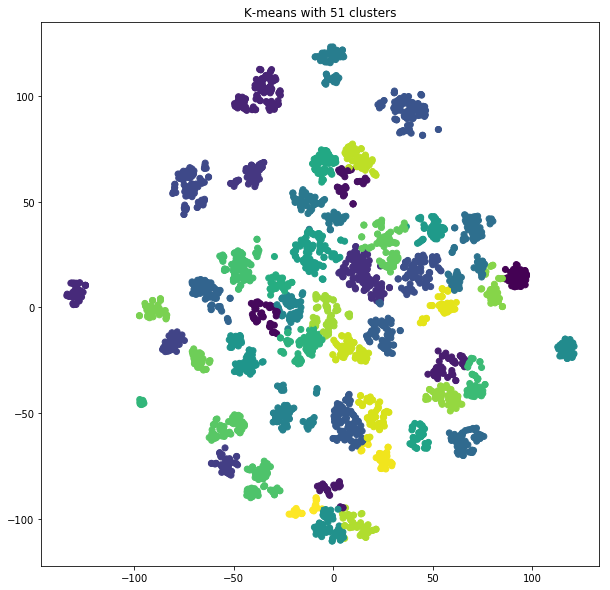

In [107]:
fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_labels_51)
plt.title("K-means with 51 clusters");

#### Number of clusters 55

In [108]:
kmeans_55 = cluster.KMeans(n_clusters=55,init='k-means++')
kmeans_55.fit(X_norm);

In [109]:
X_labels_55 = kmeans_55.labels_
X_labels_55.shape

(3733,)

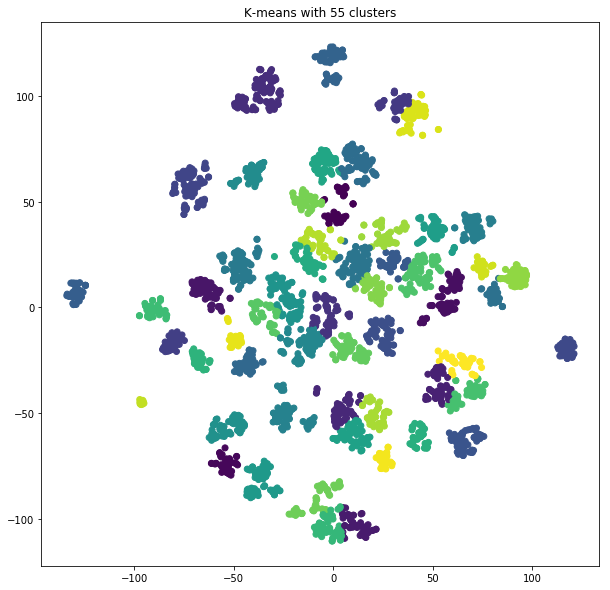

In [110]:
fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=X_labels_55)
plt.title("K-means with 55 clusters");

#### Some visual inspection

In [111]:
# Correspondance movie_title <-> label
df_correspondance = pd.DataFrame({'movie_title':Yk,'labels_34':X_labels ,'labels_51':X_labels_51,'labels_55': X_labels_55,\
                                  'X_nom1':X_norm[:,0], 'X_nom2':X_norm[:,1],'release_year':df_movies_clean.title_year.values,\
                                 'genre':df_movies_clean.genres.values,'content_rating':df_movies_clean.content_rating.values })

In [112]:
# according to labels_34
df_correspondance.query('labels_34==3').sample(3)

,movie_title,labels_34,labels_51,labels_55,X_nom1,X_nom2,release_year,genre,content_rating
2760,A Prairie Home Companion,3,11,11,-74.441566,61.955818,2006,Comedy|Drama|Music,PG-13
3151,House Party 2,3,11,11,-70.497749,58.189320,1991,Comedy|Drama|Music|Romance,R
2158,Kansas City,3,11,11,-79.131058,54.269711,1996,Crime|Drama|Music|Thriller,R


In [113]:
# according to labels_51
df_correspondance.query('labels_51==6').sample(3)

,movie_title,labels_34,labels_51,labels_55,X_nom1,X_nom2,release_year,genre,content_rating
3652,Tarnation,16,6,16,-130.657135,4.726706,2003,Biography|Documentary,R
3732,My Date with Drew,16,6,16,-127.964119,8.063297,2004,Documentary,PG
2618,Katy Perry: Part of Me,16,6,16,-129.072876,11.292512,2012,Documentary|Music,PG


In [114]:
# according to labels_55
df_correspondance.query('labels_55==6').sample(3)

,movie_title,labels_34,labels_51,labels_55,X_nom1,X_nom2,release_year,genre,content_rating
2330,Wasabi,12,14,6,3.940792,-48.880821,2001,Action|Comedy|Crime|Drama|Thriller,R
3230,Exiled,12,14,6,4.294048,-47.446831,2006,Action|Crime|Thriller,R
3215,Only God Forgives,12,14,6,2.559122,-54.349964,2013,Crime|Drama,R


#### We'll add the different computed labels to the dataset

##### Code

In [115]:
df_movies_clean[['labels_34','labels_51','labels_55']] = df_correspondance[['labels_34','labels_51','labels_55']]

##### Test

In [116]:
df_movies_clean.head(3)[['movie_title','labels_34','labels_51','labels_55']]

,movie_title,labels_34,labels_51,labels_55
0,Avatar,30,7,21
1,Pirates of the Caribbean: At World's End,30,7,21
2,Spectre,30,7,21


In [117]:
df_correspondance.head(3)

,movie_title,labels_34,labels_51,labels_55,X_nom1,X_nom2,release_year,genre,content_rating
0,Avatar,30,7,21,6.292254,20.972807,2009,Action|Adventure|Fantasy|Sci-Fi,PG-13
1,Pirates of the Caribbean: At World's End,30,7,21,6.305608,17.988419,2007,Action|Adventure|Fantasy,PG-13
2,Spectre,30,7,21,11.330832,28.761490,2015,Action|Adventure|Thriller,PG-13


#### What are the amount of movies per cluster

##### 34 Clusters

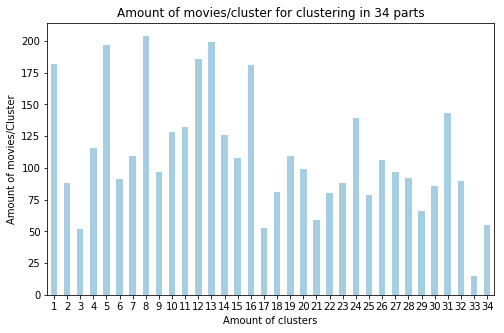

In [118]:
df_34 = df_movies_clean.groupby('labels_34')['title_year'].count()
df_34.plot( y='title_year', kind='bar', colormap='Paired',figsize=(8,5));
plt.title('Amount of movies/cluster for clustering in 34 parts')
ticks_x =[]
labels_x = []
for i in df_34.index:
    ticks_x.append(i)
    labels_x.append(str(i+1))
plt.xticks(ticks_x,labels_x)
plt.xticks(rotation=0)
plt.xlabel("Amount of clusters")
plt.ylabel('Amount of movies/Cluster');

##### 51 Clusters

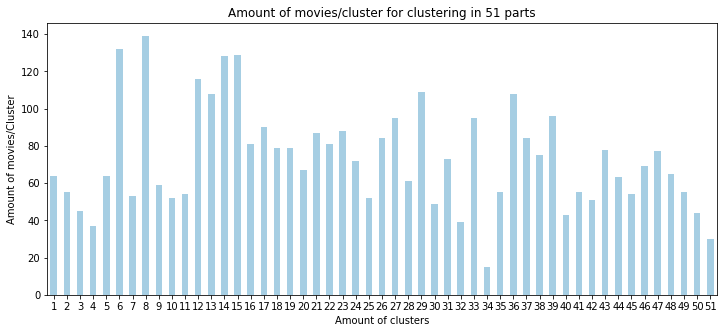

In [119]:
df_51 = df_movies_clean.groupby('labels_51')['title_year'].count()
df_51.plot( y='title_year', kind='bar', colormap='Paired',figsize=(12,5));
plt.title('Amount of movies/cluster for clustering in 51 parts')
ticks_x =[]
labels_x = []
for i in df_51.index:
    ticks_x.append(i)
    labels_x.append(str(i+1))
plt.xticks(ticks_x,labels_x)
plt.xticks(rotation=0)
plt.xlabel("Amount of clusters")
plt.ylabel('Amount of movies/Cluster');

##### 55 Clusters

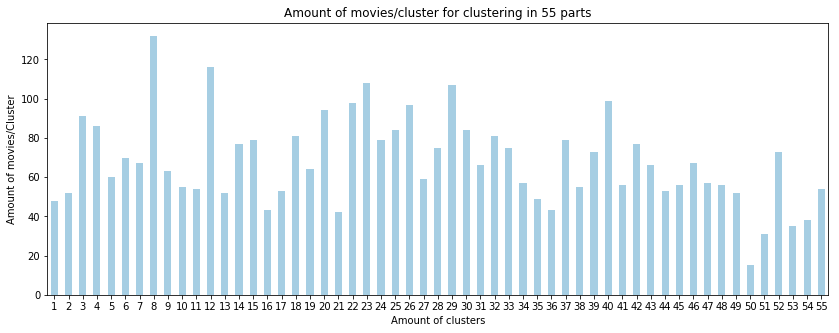

In [120]:
df_55 = df_movies_clean.groupby('labels_55')['title_year'].count()
df_55.plot( y='title_year', kind='bar', colormap='Paired',figsize=(14,5));
plt.title('Amount of movies/cluster for clustering in 55 parts')
ticks_x =[]
labels_x = []
for i in df_55.index:
    ticks_x.append(i)
    labels_x.append(str(i+1))
plt.xticks(ticks_x,labels_x)
plt.xticks(rotation=0)
plt.xlabel("Amount of clusters")
plt.ylabel('Amount of movies/Cluster');

In [121]:
df_55.min()

15

### Agglomerative Clustering

In [122]:
# to change number of clusters
nb_of_clusters = 20

In [123]:
from sklearn.cluster import AgglomerativeClustering
agglo_clustering = AgglomerativeClustering(linkage="ward", n_clusters=nb_of_clusters)
agglo_clustering.fit(X_norm)
agglo_labels = agglo_clustering.labels_ ;

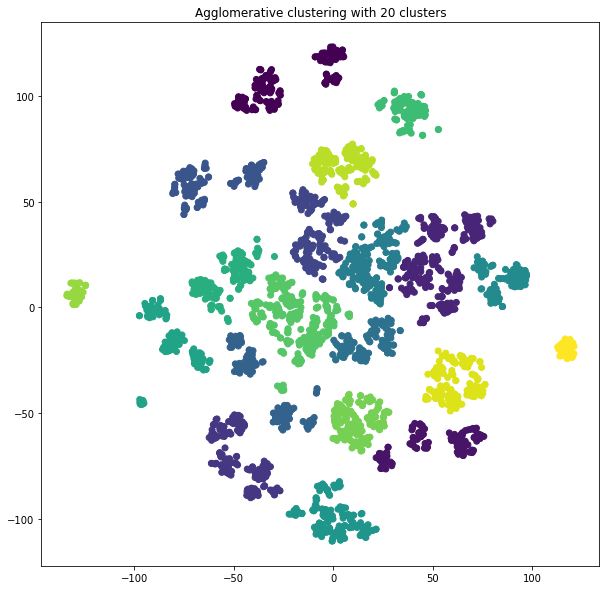

In [124]:
fig = plt.figure(figsize=(10,10))
plt.scatter(X_norm[:,0],X_norm[:,1],c=agglo_labels)
plt.title(f'Agglomerative clustering with {nb_of_clusters} clusters');

#### Dendrograms

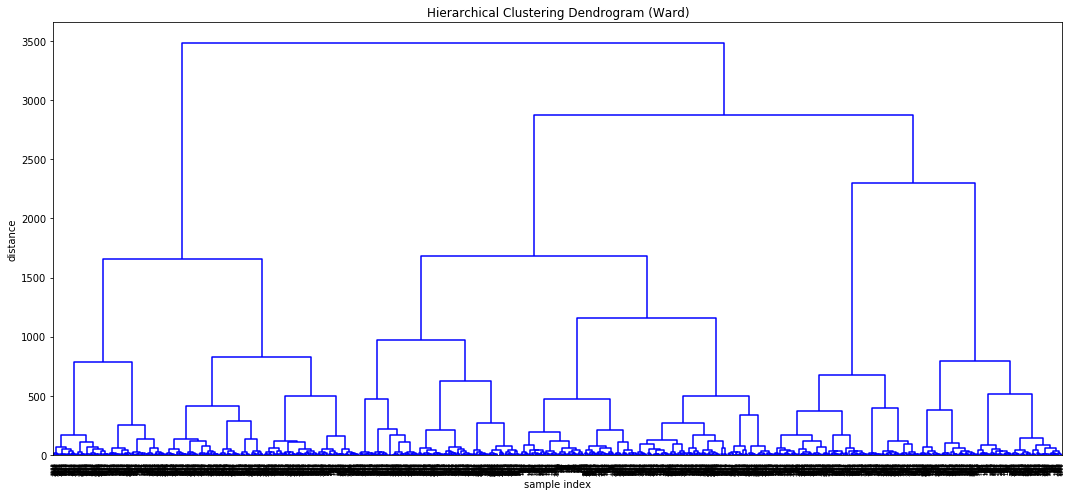

In [125]:
# source : https://trainingdatascience.com/workshops/hierarchical-clustering---agglomerative/
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X_norm, 'ward')
figure = plt.figure(figsize=(15,7))

dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

In [126]:
# Correspondance movie_title <-> label
df_agglo = pd.DataFrame({'movie_title':Yk,'agglo_labels':agglo_labels ,'X_nom1':X_norm[:,0], 'X_nom2':X_norm[:,1],
                         'release_year':df_movies_clean.title_year.values,'genre':df_movies_clean.genres.values,
                         'content_rating':df_movies_clean.content_rating.values })

In [127]:
df_movies_clean['agglo_labels'] = df_agglo['agglo_labels']

#### Comments:
> - here difficulty to choose the ideal amount of clusters (compared to the K-means with the silhouette coefficients), so we prefered to focus on the K-means++.

<a id='similarities'></a>
## Similarities within one cluster
<a href="#table">back to content table</a>

> After reducing the dimension of the dataset to 2D, through a t-SNE, we applyed a K-means on the dataset to get differtent movie clusters. Now we would like to compute the similarities between movies of a certain cluster.

> As measure of distance, we'll use the cosine similarity.

### Pre-work before computing cosine similarities

> To measure similarties, we'll create a metadata for every movie containing: director_name, actor_1/2/3_name and plot_keywords. We'll use a Count Vectorizer to create a count matrix. This will allow us to compute the cosine similarities with regards to this count_matrix.

#### Cast members

In [128]:
# Put the cast members name in lower case
df_movies_clean[['director_name','actor_1_name','actor_2_name','actor_3_name']] =\
                df_movies_clean[['director_name','actor_1_name','actor_2_name','actor_3_name']].apply(lambda x: x.str.lower())

In [129]:
df_movies_clean[['movie_title','director_name','actor_1_name','actor_2_name','actor_3_name']].sample(3)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name
1721,Self/less,tarsem singh,ryan reynolds,derek luke,sandra ellis lafferty
1528,Letters to Juliet,gary winick,vanessa redgrave,marcia debonis,luisa ranieri
1580,Alex & Emma,rob reiner,david paymer,lobo sebastian,robert costanzo


In [130]:
# to give more weight to the director relative to the actors, one of the options is to mention each director 3 times
df_movies_clean['director_name_3X'] = df_movies_clean['director_name'].apply(lambda x: [x,x,x])

In [131]:
df_movies_clean[['director_name','director_name_3X']].sample(3)

,director_name,director_name_3X
510,thor freudenthal,"[thor freudenthal, thor freudenthal, thor freu..."
406,jon amiel,"[jon amiel, jon amiel, jon amiel]"
24,peter jackson,"[peter jackson, peter jackson, peter jackson]"


#### Keywords

##### How frequent are keywords

In [132]:
# making sure each row of 'plot_keywords' is a list of keywords
df_movies_clean['plot_keywords'] = df_movies_clean['plot_keywords'].apply(lambda x:\
                                  x.replace("[","").replace("]","").replace("'","").split(', '))                                       

In [133]:
df_movies_clean.plot_keywords.sample(1)

882    [abbreviation in title, reporter, small town, ...
Name: plot_keywords, dtype: object

In [134]:
# 1.) create a series from each row (plot_keywords) containing a list 2.) stack all those series
keyword_series = df_movies_clean.apply(lambda x: pd.Series(x['plot_keywords']),axis=1).stack().reset_index(level=1, drop=True)
keyword_series.name = 'keywords'

In [135]:
keyword_series = keyword_series.value_counts()
keyword_series[:5]

love      147
friend    135
murder    128
death     101
police     91
Name: keywords, dtype: int64

In [136]:
# Only keep keywords that are used more than once 
keyword_series = keyword_series[keyword_series>1]

In [137]:
# We want to avoid making difference between singular and plural words (no difference "friend" and "friends")
# We'll convert them to their stem
# We'll use therefor SnowballStemmer 
stemmer = SnowballStemmer('english')

In [138]:
# Function to keep only keywords present in keyword_series (= appearing more than once)
def adapt_keywords(x):
    words = []
    for i in x:
        #print(i)
        if i in keyword_series:
            words.append(stemmer.stem(i))
    return words

In [139]:
df_movies_clean['plot_keywords'] = df_movies_clean['plot_keywords'].apply(adapt_keywords)

In [140]:
df_movies_clean.plot_keywords.head(3)

0                      [avatar, futur, marin]
1           [goddess, marriage propos, pirat]
2    [bomb, espionag, sequel, spi, terrorist]
Name: plot_keywords, dtype: object

In [141]:
# Before bringing "plot_keywords", "actor_1_name", "actor_2_name", "actor_3_name" and "director_name" to one soup, 
# we need to convert "actor_1_name", "actor_2_name", "actor_3_name" to lists
df_movies_clean['actor_1_name_01'] = df_movies_clean['actor_1_name'].apply(lambda x: [x[:len(x)]])
df_movies_clean['actor_2_name_01'] = df_movies_clean['actor_2_name'].apply(lambda x: [x[:len(x)]])
df_movies_clean['actor_3_name_01'] = df_movies_clean['actor_3_name'].apply(lambda x: [x[:len(x)]])

In [142]:
df_movies_clean['actor_1_name_01'].head(3)

0        [cch pounder]
1        [johnny depp]
2    [christoph waltz]
Name: actor_1_name_01, dtype: object

In [143]:
df_movies_clean['soup'] = df_movies_clean['plot_keywords'] + df_movies_clean['actor_1_name_01'] + df_movies_clean['actor_2_name_01']\
                        + df_movies_clean['actor_3_name_01'] + df_movies_clean['director_name_3X']


##### Test

In [144]:
df_movies_clean.soup.head(1).values

array([list(['avatar', 'futur', 'marin', 'cch pounder', 'joel david moore', 'wes studi', 'james cameron', 'james cameron', 'james cameron'])],
      dtype=object)

In [145]:
df_movies_clean['soup'] = df_movies_clean['soup'].apply(lambda x: ' '.join(x))

In [146]:
df_movies_clean.soup.head(1).values

array(['avatar futur marin cch pounder joel david moore wes studi james cameron james cameron james cameron'],
      dtype=object)

### Compute the cosine similarities on the concerned cluster

In [147]:
def get_cluster_cosine(df_cluster,soup_type):
    count_vector = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    count_matrix = count_vector.fit_transform(df_cluster[soup_type])
    cosine_sim = cosine_similarity(count_matrix, count_matrix)
    # Inspecting the count_matrix
    #df_matrix = pd.DataFrame(count_matrix.A[:,:100], columns=count_vector.get_feature_names()[:100])
    #print(df_matrix.head(5))
    return cosine_sim


<a id='recommendations'></a>
## Get the movie recommendations
<a href="#table">back to content table</a>

In [148]:
# If movie_title is found in db => returns a list of labels_34, labels_51, labels_55
# Input: movie_title
# Output: list with labels of corresponding clusters
def get_labels(movie_name):
    cluster_labels = df_movies_clean.query('movie_title == @movie_name')[['labels_34','labels_51','labels_55','agglo_labels']].values
    if cluster_labels.shape[0] == 0:
        #print("Movie title wasn't found in the database")
        return [-1,0,0,0]
    else:
        return cluster_labels[0] 

In [149]:
# Input: cluster label list (=out put of get_labels()) + type of label (labels_34, labels_51,labels_55)
# Output: df with all movies corresponding to this cluster label
def get_movies_cluster(list_label_number, label_type):
    if label_type == "labels_34":
        label = list_label_number[0]
        return df_movies_clean.query('labels_34 == @label')
    elif label_type == "labels_51":
        label = list_label_number[1]
        return df_movies_clean.query('labels_51 == @label')
    elif label_type == "labels_55":
        label = list_label_number[2]
        return df_movies_clean.query('labels_55 == @label')
    elif label_type == "agglo_labels":
        label = list_label_number[3]
        return df_movies_clean.query('agglo_labels == @label')
    else:
        print("An empty label list was given")
        return

In [150]:
movie_titles = df_movies_clean["movie_title"].values

In [151]:
def get_similar_movies(movie_title,movies_in_cluster,cosine_sim,indices,nb_movies=5):
    # Getting back the corresponding index to the given movie_title
    if(movie_title not in movie_titles):
        print("Given movie title is wrong or isn't in de dataset")
    else: 
        idx = indices[movie_title]
        # list of 3733 tuples containing (index , cosine_similarity) with respect to the given movie_title
        # = corresponding row in cosine_sim converted to a list
        list_scores = list(enumerate(cosine_sim[idx]))
        # sorted list in descending order => get most similar movies first
        sorted_scores = sorted(list_scores, key=lambda x: x[1], reverse=True)
        # slicing the list according to nb_movies
        # starting i at 1 as 0 is the movie_title given as input
        sorted_scores = sorted_scores[1:nb_movies+1] 
        movie_indices = [i[0] for i in sorted_scores]
        return movies_in_cluster.iloc[movie_indices]

In [152]:
def get_recommendation(movie_title,label="labels_55",nb_movies=5,soup_type='soup'):
    # get the label_nb of the movies
    label_nb = get_labels(movie_title)
    if label_nb[0] == (-1):
        print("Movie title is wrong or isn't in the dataset")
        #print(label_nb)
    else:
        # getting all the movies corresponding to this label
        df_cluster = get_movies_cluster(label_nb,label)
        df_cluster = df_cluster.reset_index()
        movies_in_cluster = df_cluster['movie_title']
        indices = pd.Series(df_cluster.index, index=df_cluster['movie_title'])
        # get the cosine similarities for this specific clust
        cluster_cosine_sim = get_cluster_cosine(df_cluster,soup_type)
        # get the recommendations
        advised_movies = get_similar_movies(movie_title,movies_in_cluster,cluster_cosine_sim,indices,nb_movies)
        return advised_movies

<a id='performance'></a>
## Performance analysis
<a href="#table">back to content table</a>

In [153]:
def movie_features(initial_movie,movies_list):
    df = df_movies_clean.query('movie_title == @initial_movie')[['movie_title', 'title_year','budget','gross','imdb_score',  
                                                                 'movie_facebook_likes', 'country','content_rating',
                                                                 'genres']]
    for movie in movies_list:
        df_m = df_movies_clean.query('movie_title == @movie')[['movie_title', 'title_year','budget','gross','imdb_score',  
                                                                 'movie_facebook_likes','country','content_rating',
                                                                 'genres']]
        df = df.append(df_m, ignore_index=True)
    return df

In [154]:
def movie_cast(initial_movie,movies_list):
    df = df_movies_clean.query('movie_title == @initial_movie')[['movie_title','director_name','actor_1_name',
                                                                 'actor_2_name','actor_3_name','plot_keywords']]
    for movie in movies_list:
        df_m = df_movies_clean.query('movie_title == @movie')[['movie_title','director_name','actor_1_name',
                                                               'actor_2_name','actor_3_name','plot_keywords']]
        df = df.append(df_m, ignore_index=True)
    return df    

#### 5 types of movies

In [155]:
# Action
spectre = get_recommendation("Spectre","labels_55",5)

# Comics
dark_knight = get_recommendation("The Dark Knight","labels_55",5)
avengers = get_recommendation("The Avengers","labels_55",5)

# Horror
paranormal = get_recommendation("Paranormal Activity","labels_55",5)
insidious = get_recommendation("Insidious","labels_55",5)

# adventure
indiana = get_recommendation("Indiana Jones and the Kingdom of the Crystal Skull","labels_55",5)
avatar = get_recommendation("Avatar","labels_55",5)

# classic
shawshank = get_recommendation("The Shawshank Redemption","labels_55",5)

#### Action

In [156]:
movie_features("Spectre",spectre.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Spectre,2015,245000000,200074175,6.8,85000,UK,PG-13,Action|Adventure|Thriller
1,Skyfall,2012,200000000,304360277,7.8,80000,UK,PG-13,Action|Adventure|Thriller
2,Spider-Man 3,2007,258000000,336530303,6.2,0,USA,PG-13,Action|Adventure|Romance
3,Spider-Man 2,2004,200000000,373377893,7.3,0,USA,PG-13,Action|Adventure|Fantasy|Romance
4,Spider-Man,2002,139000000,403706375,7.3,5000,USA,PG-13,Action|Adventure|Fantasy|Romance
5,Pirates of the Caribbean: On Stranger Tides,2011,250000000,241063875,6.7,58000,USA,PG-13,Action|Adventure|Fantasy


In [157]:
movie_cast("Spectre",spectre.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Spectre,sam mendes,christoph waltz,rory kinnear,stephanie sigman,"[bomb, espionag, sequel, spi, terrorist]"
1,Skyfall,sam mendes,albert finney,helen mccrory,rory kinnear,"[childhood hom, intelligence ag]"
2,Spider-Man 3,sam raimi,j.k. simmons,james franco,kirsten dunst,"[spider man, villain]"
3,Spider-Man 2,sam raimi,j.k. simmons,james franco,kirsten dunst,"[death, doctor, scientist, super villain]"
4,Spider-Man,sam raimi,j.k. simmons,james franco,kirsten dunst,"[evil, spider, spider man, superhero]"
5,Pirates of the Caribbean: On Stranger Tides,rob marshall,johnny depp,sam claflin,stephen graham,"[captain, pirat, reveng, soldier]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>   * Genres = Action, Adventure, Thriller
>   * Coherent content_rating (PG-13)
>   * Similar IMDB_scores
> - If we look at the cast and keywords (used for the cosine similarities):
>   * We observe that the focus was probably placed separately on the director's first name : "Sam". So a possible improvement, would be to join the first names and last names.
> - *** General comment***: Second recommendation "Skyfall" is good, but having 3 Spider-Man's is strange.

#### Comics

In [158]:
movie_features("The Dark Knight",dark_knight.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,The Dark Knight,2008,185000000,533316061,9.0,37000,USA,PG-13,Action|Crime|Drama|Thriller
1,The Dark Knight Rises,2012,250000000,448130642,8.5,164000,USA,PG-13,Action|Thriller
2,Interstellar,2014,165000000,187991439,8.6,349000,USA,PG-13,Adventure|Drama|Sci-Fi
3,Inception,2010,160000000,292568851,8.8,175000,USA,PG-13,Action|Adventure|Sci-Fi|Thriller
4,Man of Steel,2013,225000000,291021565,7.2,118000,USA,PG-13,Action|Adventure|Fantasy|Sci-Fi
5,Batman v Superman: Dawn of Justice,2016,250000000,330249062,6.9,197000,USA,PG-13,Action|Adventure|Sci-Fi


In [159]:
movie_cast("The Dark Knight",dark_knight.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,The Dark Knight,christopher nolan,christian bale,heath ledger,morgan freeman,"[based on comic book, dc comic, psychopath, st..."
1,The Dark Knight Rises,christopher nolan,tom hardy,christian bale,joseph gordon-levitt,"[decept, imprison, police offic, terrorist plot]"
2,Interstellar,christopher nolan,matthew mcconaughey,anne hathaway,mackenzie foy,"[father daughter relationship, space travel]"
3,Inception,christopher nolan,leonardo dicaprio,tom hardy,joseph gordon-levitt,"[ambiguous end, dream, thief]"
4,Man of Steel,zack snyder,henry cavill,christopher meloni,harry lennix,"[based on comic book, final battl, reboot]"
5,Batman v Superman: Dawn of Justice,zack snyder,henry cavill,lauren cohan,alan d. purwin,"[based on comic book, superhero, superman]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>    * Most recommended movies are Action, Adventure, Thriller genre
>    * Consistent content_rating
>    * Similar imdb_score
>    * Release years spread from 2008 till 2016
> - If we look at the cast and keywords (used for the cosine similarities):
>    * Here we see once again priority to director ("Christopher Nolan"), for the last 2 recommendations probably linked to keywords ("based on comic book")

> ***General comment:*** In general, good recommendations

In [160]:
movie_features("The Avengers",avengers.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,The Avengers,2012,220000000,623279547,8.1,123000,USA,PG-13,Action|Adventure|Sci-Fi
1,Avengers: Age of Ultron,2015,250000000,458991599,7.5,118000,USA,PG-13,Action|Adventure|Sci-Fi
2,Captain America: Civil War,2016,250000000,407197282,8.2,72000,USA,PG-13,Action|Adventure|Sci-Fi
3,Iron Man 2,2010,200000000,312057433,7.0,18000,USA,PG-13,Action|Adventure|Sci-Fi
4,Iron Man 3,2013,200000000,408992272,7.2,95000,USA,PG-13,Action|Adventure|Sci-Fi
5,Iron Man,2008,140000000,318298180,7.9,10000,USA,PG-13,Action|Adventure|Sci-Fi


In [161]:
movie_cast("The Avengers",avengers.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,The Avengers,joss whedon,chris hemsworth,robert downey jr.,scarlett johansson,"[alien invas, assassin, battl, soldier]"
1,Avengers: Age of Ultron,joss whedon,chris hemsworth,robert downey jr.,scarlett johansson,"[artificial intellig, based on comic book, cap..."
2,Captain America: Civil War,anthony russo,robert downey jr.,scarlett johansson,chris evans,"[based on comic book, knife, marvel cinematic ..."
3,Iron Man 2,jon favreau,robert downey jr.,scarlett johansson,jon favreau,"[militari, reveng]"
4,Iron Man 3,shane black,robert downey jr.,jon favreau,don cheadle,"[armor, explos, terrorist]"
5,Iron Man,jon favreau,robert downey jr.,jeff bridges,jon favreau,"[afghanistan, billionair, inventor, playboy, u..."


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>   * Genres = Action, Adventure, Sci-Fi
>   * Coherent content_rating
>   * Similar IMDB_scores
> - If we look at the cast and keywords (used for the cosine similarities):
>   * director : "Joss Whedon" and actor: "Robert Downey jr" are coming several times back
> - *** General comment***: good recommendations (all comics, with Joss Whedon as director or Robert Downey Jr as actor)

#### Horror

In [162]:
movie_features("Paranormal Activity",paranormal.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Paranormal Activity,2007,15000,107917283,6.3,12000,USA,R,Horror
1,Paranormal Activity 2,2010,3000000,84749884,5.7,14000,USA,R,Horror
2,The Blair Witch Project,1999,60000,140530114,6.4,0,USA,R,Horror
3,The Devil Inside,2012,1000000,53245055,4.2,12000,USA,R,Horror
4,The Wolfman,2010,150000000,61937495,5.8,0,USA,R,Drama|Fantasy|Horror|Thriller
5,Underworld: Awakening,2012,70000000,62321039,6.4,24000,USA,R,Action|Fantasy|Horror


In [163]:
movie_cast("Paranormal Activity",paranormal.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Paranormal Activity,oren peli,micah sloat,ashley palmer,amber armstrong,[found footag]
1,Paranormal Activity 2,tod williams,sprague grayden,molly ephraim,micah sloat,"[california, hous, nanni, security camera]"
2,The Blair Witch Project,daniel myrick,heather donahue,joshua leonard,michael c. williams,"[found footag, looking at the camera, maryland]"
3,The Devil Inside,william brent bell,fernanda andrade,claudiu trandafir,brian johnson,"[critically bash, demonic possess, exorc, exor..."
4,The Wolfman,joe johnston,anthony hopkins,simon merrells,art malik,"[asylum, death, transform, werewolf]"
5,Underworld: Awakening,måns mårlind,theo james,stephen rea,sandrine holt,"[battl, detect, scientist, vampir]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>   * All movies are "Horror movies" with same content_rating
>   * Similar imdb_score
>   * Release year going from 1999 till 2012
> - If we look at the cast and keywords (used for the cosine similarities):
>   * keywords: found footage, ... camera
> - *** General comment:*** Good recommendations (Paranormal Activity 2, The Blair Witch Project)

In [164]:
movie_features("Insidious",insidious.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Insidious,2010,1500000,53991137,6.8,60000,USA,PG-13,Fantasy|Horror|Mystery|Thriller
1,Saw,2004,1200000,55153403,7.7,0,USA,R,Horror|Mystery|Thriller
2,The Conjuring 2,2016,40000000,102310175,7.8,40000,USA,R,Horror|Mystery|Thriller
3,The Conjuring,2013,20000000,137387272,7.5,131000,USA,R,Horror|Mystery|Thriller
4,Exorcist: The Beginning,2004,50000000,41814863,5.1,893,USA,R,Horror|Mystery|Thriller
5,Oculus,2013,5000000,27689474,6.5,23000,USA,R,Horror|Mystery


In [165]:
movie_cast("Insidious",insidious.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Insidious,james wan,lin shaye,barbara hershey,philip friedman,"[babi, boy, coma, demon, hous]"
1,Saw,james wan,michael emerson,monica potter,shawnee smith,"[flashback, killer, serial kil, surprise end]"
2,The Conjuring 2,james wan,javier botet,frances o'connor,robin atkin downes,"[based on supposedly true stori, hous, psychic..."
3,The Conjuring,james wan,mackenzie foy,lili taylor,hayley mcfarland,"[based on true stori, farmhous, paranormal inv..."
4,Exorcist: The Beginning,renny harlin,james d'arcy,alan ford,izabella scorupco,"[archeologist, church, faith, relic]"
5,Oculus,mike flanagan,james lafferty,rory cochrane,garrett ryan,"[mirror, trauma, video camera]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>     * All Horror, Mystery(and Thriller) movies, and all recommendations have a R content_rating.
>     * Similar content_rating
> - If we look at the cast and keywords (used for the cosine similarities):
>     *  We observe here the director : "James Wan"

#### Adventure

In [166]:
movie_features("Indiana Jones and the Kingdom of the Crystal Skull",indiana.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Indiana Jones and the Kingdom of the Crystal S...,2008,185000000,317011114,6.2,5000,USA,PG-13,Action|Adventure|Fantasy
1,Indiana Jones and the Temple of Doom,1984,28000000,179870271,7.6,0,USA,PG,Action|Adventure
2,Raiders of the Lost Ark,1981,18000000,242374454,8.5,16000,USA,PG,Action|Adventure
3,Indiana Jones and the Last Crusade,1989,48000000,197171806,8.3,0,USA,PG-13,Action|Adventure|Fantasy
4,E.T. the Extra-Terrestrial,1982,10500000,434949459,7.9,34000,USA,PG,Family|Sci-Fi
5,The Adventures of Tintin,2011,135000000,77564037,7.4,44000,USA,PG,Action|Adventure|Family|Mystery


In [167]:
movie_cast("Indiana Jones and the Kingdom of the Crystal Skull",indiana.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Indiana Jones and the Kingdom of the Crystal S...,steven spielberg,harrison ford,ray winstone,jim broadbent,"[femme fatal, unsubtitled foreign languag]"
1,Indiana Jones and the Temple of Doom,steven spielberg,harrison ford,amrish puri,kate capshaw,"[children, templ, villag]"
2,Raiders of the Lost Ark,steven spielberg,harrison ford,karen allen,william hootkins,"[archeologist, egypt, nazi]"
3,Indiana Jones and the Last Crusade,steven spielberg,harrison ford,julian glover,alison doody,"[castl, diari, holy grail, map, nazi]"
4,E.T. the Extra-Terrestrial,steven spielberg,henry thomas,dee wallace,peter coyote,"[boy, doll]"
5,The Adventures of Tintin,steven spielberg,toby jones,mackenzie crook,tony curran,"[captain, morocco, ship, treasur]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>   * All movies are Adventure genre, some are Action and Sci-Fi too.
>   * Coherent content_rating
>   * Release years varying from 1981 till 2008
> - If we look at the cast and keywords (used for the cosine similarities):
>   * All movies are from "Steven Spielberg", and the first 3 recommendations are with actor "Harrison Ford"

In [168]:
movie_features("Avatar",avatar.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Avatar,2009,237000000,760505847,7.9,33000,USA,PG-13,Action|Adventure|Fantasy|Sci-Fi
1,Titanic,1997,200000000,658672302,7.7,26000,USA,PG-13,Drama|Romance
2,The Wolverine,2013,120000000,132550960,6.7,68000,USA,PG-13,Action|Adventure|Sci-Fi|Thriller
3,Guardians of the Galaxy,2014,170000000,333130696,8.1,96000,USA,PG-13,Action|Adventure|Sci-Fi
4,Spider-Man 3,2007,258000000,336530303,6.2,0,USA,PG-13,Action|Adventure|Romance
5,Spider-Man 2,2004,200000000,373377893,7.3,0,USA,PG-13,Action|Adventure|Fantasy|Romance


In [169]:
movie_cast("Avatar",avatar.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Avatar,james cameron,cch pounder,joel david moore,wes studi,"[avatar, futur, marin]"
1,Titanic,james cameron,leonardo dicaprio,kate winslet,gloria stuart,"[artist, love, ship, titan]"
2,The Wolverine,james mangold,hugh jackman,tao okamoto,rila fukushima,[self heal]
3,Guardians of the Galaxy,james gunn,bradley cooper,vin diesel,djimon hounsou,"[bounty hunt, outer spac, raccoon, talking ani..."
4,Spider-Man 3,sam raimi,j.k. simmons,james franco,kirsten dunst,"[spider man, villain]"
5,Spider-Man 2,sam raimi,j.k. simmons,james franco,kirsten dunst,"[death, doctor, scientist, super villain]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>    * Besides "Titanic" all movies are all Action and/or Adventure movies
>    * content_rating : coherent
>    * similar imdb_score
> - If we look at the cast and keywords (used for the cosine similarities):
>    * Here again it seems that the "First name = James" has been emphasized separately

#### Classics

In [170]:
movie_features("The Shawshank Redemption",shawshank.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,The Shawshank Redemption,1994,25000000,28341469,9.3,108000,USA,R,Crime|Drama
1,Sin City,2005,40000000,74098862,8.1,13000,USA,R,Crime|Thriller
2,The Grand Budapest Hotel,2014,25000000,59073773,8.1,149000,USA,R,Adventure|Comedy|Crime|Drama
3,American History X,1998,7500000,6712241,8.6,35000,USA,R,Crime|Drama
4,Face/Off,1997,80000000,112225777,7.3,11000,USA,R,Action|Crime|Sci-Fi|Thriller
5,Death Race,2008,45000000,36064910,6.4,0,USA,R,Action|Sci-Fi|Thriller


In [171]:
movie_cast("The Shawshank Redemption",shawshank.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,The Shawshank Redemption,frank darabont,morgan freeman,jeffrey demunn,bob gunton,"[escape from prison, first person narr, prison]"
1,Sin City,frank miller,rosario dawson,powers boothe,jason douglas,"[antholog, corrupt, neo noir, night]"
2,The Grand Budapest Hotel,wes anderson,bill murray,tom wilkinson,f. murray abraham,"[first person narr, hotel, mentor protege rela..."
3,American History X,tony kaye,ethan suplee,beverly d'angelo,stacy keach,"[neo nazi, prison]"
4,Face/Off,john woo,nicolas cage,cch pounder,joan allen,"[death of child, prison, terrorist]"
5,Death Race,paul w.s. anderson,jason statham,max ryan,joan allen,"[armored car, car, murder, prison, warden]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>    * Almost all movies are Crime genres, and most are Drama too (and or Thriller).
>    * coherent content_rating
> - If we look at the cast and keywords (used for the cosine similarities):
>    * Two first movies are from directors who's firtname is "Frank". The keyword "prison" is also coming often back.

### Improving recommendation

#### Joining actor names and director names!!

> As we saw in the evaluation of the recommendations, sometimes the model seems to look at similarities based only on the firstname or lastname, instead of the combination of both. So we'll try to improve this aspect, by joining the first- and lastname together.

##### ACTORS

In [172]:
df_movies_clean.actor_1_name.head(3)

0        cch pounder
1        johnny depp
2    christoph waltz
Name: actor_1_name, dtype: object

In [173]:
df_movies_clean['actor_1_name_1wrd'] = df_movies_clean['actor_1_name'].apply(lambda x: x.replace(' ',''))
df_movies_clean['actor_2_name_1wrd'] = df_movies_clean['actor_2_name'].apply(lambda x: x.replace(' ',''))
df_movies_clean['actor_3_name_1wrd'] = df_movies_clean['actor_3_name'].apply(lambda x: x.replace(' ',''))

In [174]:
# Test
df_movies_clean.head(3)[['actor_1_name_1wrd','actor_2_name_1wrd','actor_3_name_1wrd']]

,actor_1_name_1wrd,actor_2_name_1wrd,actor_3_name_1wrd
0,cchpounder,joeldavidmoore,wesstudi
1,johnnydepp,orlandobloom,jackdavenport
2,christophwaltz,rorykinnear,stephaniesigman


In [175]:
# Before bringing "plot_keywords", "actor_1_name", "actor_2_name", "actor_3_name" and "director_name" to one soup, 
# we need to convert "actor_1_name_1wrd", "actor_2_name_1wrd", "actor_3_name_1wrd" to lists
df_movies_clean['actor_1_name_02'] = df_movies_clean['actor_1_name_1wrd'].apply(lambda x: [x[:len(x)]])
df_movies_clean['actor_2_name_02'] = df_movies_clean['actor_2_name_1wrd'].apply(lambda x: [x[:len(x)]])
df_movies_clean['actor_3_name_02'] = df_movies_clean['actor_3_name_1wrd'].apply(lambda x: [x[:len(x)]])

In [176]:
# Test
df_movies_clean.head(3)[['actor_1_name_02','actor_2_name_02','actor_3_name_02']]

,actor_1_name_02,actor_2_name_02,actor_3_name_02
0,[cchpounder],[joeldavidmoore],[wesstudi]
1,[johnnydepp],[orlandobloom],[jackdavenport]
2,[christophwaltz],[rorykinnear],[stephaniesigman]


##### DIRECTORS

In [177]:
df_movies_clean['director_name_1wrd'] = df_movies_clean['director_name'].apply(lambda x: x.replace(' ',''))

In [178]:
# Test
df_movies_clean['director_name_1wrd'].head(3)

0     jamescameron
1    goreverbinski
2        sammendes
Name: director_name_1wrd, dtype: object

In [179]:
 # to give more weight to the director relative to the actors, one of the options is to mention each director 3 times
df_movies_clean['director_name_3X_02'] = df_movies_clean['director_name_1wrd'].apply(lambda x: [x,x,x])

df_movies_clean[['director_name','director_name_3X_02']].sample(3)

,director_name,director_name_3X_02
2880,dario argento,"[darioargento, darioargento, darioargento]"
50,mike newell,"[mikenewell, mikenewell, mikenewell]"
203,louis leterrier,"[louisleterrier, louisleterrier, louisleterrier]"


In [180]:
df_movies_clean['soup_02'] = df_movies_clean['plot_keywords'] + df_movies_clean['actor_1_name_02'] +\
                            df_movies_clean['actor_2_name_02']+ df_movies_clean['actor_3_name_02'] +\
                            df_movies_clean['director_name_3X_02']


In [181]:
# Test 
df_movies_clean['soup_02'].head(1)

0    [avatar, futur, marin, cchpounder, joeldavidmo...
Name: soup_02, dtype: object

In [182]:
df_movies_clean['soup_02'] = df_movies_clean['soup_02'].apply(lambda x: ' '.join(x))

##### Test

In [183]:
df_movies_clean['soup_02'].head(1).values

array(['avatar futur marin cchpounder joeldavidmoore wesstudi jamescameron jamescameron jamescameron'],
      dtype=object)

<a id='performance_after'></a>
## Performance analysis after improvement
<a href="#table">back to content table</a>

In [184]:
# Action
spectre_01 = get_recommendation("Spectre","labels_55",5,soup_type='soup_02')

# Comics
dark_knight_01 = get_recommendation("The Dark Knight","labels_55",5,soup_type='soup_02')
avengers_01 = get_recommendation("The Avengers","labels_55",5,soup_type='soup_02')

# Horror
paranormal_01 = get_recommendation("Paranormal Activity","labels_55",5,soup_type='soup_02')
insidious_01 = get_recommendation("Insidious","labels_55",5,soup_type='soup_02')

# adventure
indiana_01 = get_recommendation("Indiana Jones and the Kingdom of the Crystal Skull","labels_55",5,soup_type='soup_02')
avatar_01 = get_recommendation("Avatar","labels_55",5,soup_type='soup_02')

# classic
shawshank_01 = get_recommendation("The Shawshank Redemption","labels_55",5,soup_type='soup_02')

#### Action

In [185]:
spectre

22                                        Skyfall
5                                    Spider-Man 3
23                                   Spider-Man 2
67                                     Spider-Man
12    Pirates of the Caribbean: On Stranger Tides
Name: movie_title, dtype: object

In [186]:
movie_features("Spectre",spectre_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Spectre,2015,245000000,200074175,6.8,85000,UK,PG-13,Action|Adventure|Thriller
1,Skyfall,2012,200000000,304360277,7.8,80000,UK,PG-13,Action|Adventure|Thriller
2,Iron Man 3,2013,200000000,408992272,7.2,95000,USA,PG-13,Action|Adventure|Sci-Fi
3,Armageddon,1998,140000000,201573391,6.6,11000,USA,PG-13,Action|Adventure|Sci-Fi|Thriller
4,Star Trek Beyond,2016,185000000,130468626,7.5,30000,USA,PG-13,Action|Adventure|Sci-Fi|Thriller
5,The Dark Knight Rises,2012,250000000,448130642,8.5,164000,USA,PG-13,Action|Thriller


In [187]:
movie_cast("Spectre",spectre_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Spectre,sam mendes,christoph waltz,rory kinnear,stephanie sigman,"[bomb, espionag, sequel, spi, terrorist]"
1,Skyfall,sam mendes,albert finney,helen mccrory,rory kinnear,"[childhood hom, intelligence ag]"
2,Iron Man 3,shane black,robert downey jr.,jon favreau,don cheadle,"[armor, explos, terrorist]"
3,Armageddon,michael bay,bruce willis,steve buscemi,will patton,"[astronaut, bomb, outer spac]"
4,Star Trek Beyond,justin lin,sofia boutella,melissa roxburgh,lydia wilson,"[hatr, sequel, space opera, star trek]"
5,The Dark Knight Rises,christopher nolan,tom hardy,christian bale,joseph gordon-levitt,"[decept, imprison, police offic, terrorist plot]"


##### Comments:
> - If we look a the features (part of parameters used for the t-SNE):
>    * Most recommended movies are Action, Adventure genre
>    * Conntent_rating is coherent
>    * Country: Spectre is joined production between US and UK so results are ok
>    * release years, varie from 1998 till 2016
>    * Budgets are of the same range
> - If we look at the cast and keywords (used for the cosine similarities):
>    * We notice that we don't find back the 3 Spiderman's.
>    * The keywords "terrorist", "sequel" and "bomb" seem important.

#### Comics

In [188]:
dark_knight

3                  The Dark Knight Rises
52                          Interstellar
53                             Inception
10                          Man of Steel
7     Batman v Superman: Dawn of Justice
Name: movie_title, dtype: object

In [189]:
movie_features("The Dark Knight",dark_knight_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,The Dark Knight,2008,185000000,533316061,9.0,37000,USA,PG-13,Action|Crime|Drama|Thriller
1,The Dark Knight Rises,2012,250000000,448130642,8.5,164000,USA,PG-13,Action|Thriller
2,Interstellar,2014,165000000,187991439,8.6,349000,USA,PG-13,Adventure|Drama|Sci-Fi
3,Inception,2010,160000000,292568851,8.8,175000,USA,PG-13,Action|Adventure|Sci-Fi|Thriller
4,Batman v Superman: Dawn of Justice,2016,250000000,330249062,6.9,197000,USA,PG-13,Action|Adventure|Sci-Fi
5,Man of Steel,2013,225000000,291021565,7.2,118000,USA,PG-13,Action|Adventure|Fantasy|Sci-Fi


In [190]:
movie_cast("The Dark Knight",dark_knight_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,The Dark Knight,christopher nolan,christian bale,heath ledger,morgan freeman,"[based on comic book, dc comic, psychopath, st..."
1,The Dark Knight Rises,christopher nolan,tom hardy,christian bale,joseph gordon-levitt,"[decept, imprison, police offic, terrorist plot]"
2,Interstellar,christopher nolan,matthew mcconaughey,anne hathaway,mackenzie foy,"[father daughter relationship, space travel]"
3,Inception,christopher nolan,leonardo dicaprio,tom hardy,joseph gordon-levitt,"[ambiguous end, dream, thief]"
4,Batman v Superman: Dawn of Justice,zack snyder,henry cavill,lauren cohan,alan d. purwin,"[based on comic book, superhero, superman]"
5,Man of Steel,zack snyder,henry cavill,christopher meloni,harry lennix,"[based on comic book, final battl, reboot]"


##### Comments:
> - Here basically no major changes.

In [191]:
avengers

6        Avengers: Age of Ultron
19    Captain America: Civil War
45                    Iron Man 2
24                    Iron Man 3
41                      Iron Man
Name: movie_title, dtype: object

In [192]:
movie_features("The Avengers",avengers_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,The Avengers,2012,220000000,623279547,8.1,123000,USA,PG-13,Action|Adventure|Sci-Fi
1,Avengers: Age of Ultron,2015,250000000,458991599,7.5,118000,USA,PG-13,Action|Adventure|Sci-Fi
2,Iron Man 2,2010,200000000,312057433,7.0,18000,USA,PG-13,Action|Adventure|Sci-Fi
3,Captain America: Civil War,2016,250000000,407197282,8.2,72000,USA,PG-13,Action|Adventure|Sci-Fi
4,Independence Day: Resurgence,2016,165000000,102315545,5.5,67000,USA,PG-13,Action|Adventure|Sci-Fi
5,Thor,2011,150000000,181015141,7.0,63000,USA,PG-13,Action|Adventure|Fantasy


In [193]:
movie_cast("The Avengers",avengers_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,The Avengers,joss whedon,chris hemsworth,robert downey jr.,scarlett johansson,"[alien invas, assassin, battl, soldier]"
1,Avengers: Age of Ultron,joss whedon,chris hemsworth,robert downey jr.,scarlett johansson,"[artificial intellig, based on comic book, cap..."
2,Iron Man 2,jon favreau,robert downey jr.,scarlett johansson,jon favreau,"[militari, reveng]"
3,Captain America: Civil War,anthony russo,robert downey jr.,scarlett johansson,chris evans,"[based on comic book, knife, marvel cinematic ..."
4,Independence Day: Resurgence,roland emmerich,vivica a. fox,sela ward,judd hirsch,"[alien, battl, independence day, mothership]"
5,Thor,kenneth branagh,chris hemsworth,natalie portman,anthony hopkins,"[battl, marvel cinematic univers, scientist, t..."


##### Comments:
> - director "Joss Whedon" still important, and the actor "robert downey jr" aswell.
> -  For Independence Day, we find the keywords "alien" and "battl" back

#### Horror

In [194]:
paranormal

59      Paranormal Activity 2
70    The Blair Witch Project
66           The Devil Inside
0                 The Wolfman
1       Underworld: Awakening
Name: movie_title, dtype: object

In [195]:
movie_features("Paranormal Activity",paranormal_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Paranormal Activity,2007,15000,107917283,6.3,12000,USA,R,Horror
1,Paranormal Activity 2,2010,3000000,84749884,5.7,14000,USA,R,Horror
2,The Blair Witch Project,1999,60000,140530114,6.4,0,USA,R,Horror
3,The Devil Inside,2012,1000000,53245055,4.2,12000,USA,R,Horror
4,The Wolfman,2010,150000000,61937495,5.8,0,USA,R,Drama|Fantasy|Horror|Thriller
5,Underworld: Awakening,2012,70000000,62321039,6.4,24000,USA,R,Action|Fantasy|Horror


In [196]:
movie_cast("Paranormal Activity",paranormal_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Paranormal Activity,oren peli,micah sloat,ashley palmer,amber armstrong,[found footag]
1,Paranormal Activity 2,tod williams,sprague grayden,molly ephraim,micah sloat,"[california, hous, nanni, security camera]"
2,The Blair Witch Project,daniel myrick,heather donahue,joshua leonard,michael c. williams,"[found footag, looking at the camera, maryland]"
3,The Devil Inside,william brent bell,fernanda andrade,claudiu trandafir,brian johnson,"[critically bash, demonic possess, exorc, exor..."
4,The Wolfman,joe johnston,anthony hopkins,simon merrells,art malik,"[asylum, death, transform, werewolf]"
5,Underworld: Awakening,måns mårlind,theo james,stephen rea,sandrine holt,"[battl, detect, scientist, vampir]"


##### Comments:
> - No changes

In [197]:
insidious

74                        Saw
8             The Conjuring 2
25              The Conjuring
3     Exorcist: The Beginning
60                     Oculus
Name: movie_title, dtype: object

In [198]:
movie_features("Insidious",insidious_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Insidious,2010,1500000,53991137,6.8,60000,USA,PG-13,Fantasy|Horror|Mystery|Thriller
1,The Conjuring 2,2016,40000000,102310175,7.8,40000,USA,R,Horror|Mystery|Thriller
2,Saw,2004,1200000,55153403,7.7,0,USA,R,Horror|Mystery|Thriller
3,The Conjuring,2013,20000000,137387272,7.5,131000,USA,R,Horror|Mystery|Thriller
4,Darkness Falls,2003,11000000,32131483,4.9,2000,USA,PG-13,Horror|Mystery|Thriller
5,The Mortal Instruments: City of Bones,2013,60000000,31165421,6.0,44000,USA,PG-13,Fantasy|Horror|Mystery|Romance


In [199]:
movie_cast("Insidious",insidious_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Insidious,james wan,lin shaye,barbara hershey,philip friedman,"[babi, boy, coma, demon, hous]"
1,The Conjuring 2,james wan,javier botet,frances o'connor,robin atkin downes,"[based on supposedly true stori, hous, psychic..."
2,Saw,james wan,michael emerson,monica potter,shawnee smith,"[flashback, killer, serial kil, surprise end]"
3,The Conjuring,james wan,mackenzie foy,lili taylor,hayley mcfarland,"[based on true stori, farmhous, paranormal inv..."
4,Darkness Falls,jonathan liebesman,sullivan stapleton,emma caulfield,angus sampson,"[boy, dark, light, tooth]"
5,The Mortal Instruments: City of Bones,harald zwart,aidan turner,kevin zegers,cch pounder,"[battl, demon, magic, secret, warrior]"


##### Comments:
> - Only last recommendation changed.
> - In Oculus we had the actor name : **james** lafferty
> - Here the last recommendation is probably triggered by keyword "demon"

#### Adventure

In [200]:
indiana

30    Indiana Jones and the Temple of Doom
35                 Raiders of the Lost Ark
23      Indiana Jones and the Last Crusade
50              E.T. the Extra-Terrestrial
8                 The Adventures of Tintin
Name: movie_title, dtype: object

In [201]:
movie_features("Indiana Jones and the Kingdom of the Crystal Skull",indiana_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Indiana Jones and the Kingdom of the Crystal S...,2008,185000000,317011114,6.2,5000,USA,PG-13,Action|Adventure|Fantasy
1,Indiana Jones and the Temple of Doom,1984,28000000,179870271,7.6,0,USA,PG,Action|Adventure
2,Raiders of the Lost Ark,1981,18000000,242374454,8.5,16000,USA,PG,Action|Adventure
3,E.T. the Extra-Terrestrial,1982,10500000,434949459,7.9,34000,USA,PG,Family|Sci-Fi
4,Indiana Jones and the Last Crusade,1989,48000000,197171806,8.3,0,USA,PG-13,Action|Adventure|Fantasy
5,War of the Worlds,2005,132000000,234277056,6.5,0,USA,PG-13,Adventure|Sci-Fi|Thriller


In [202]:
movie_cast("Indiana Jones and the Kingdom of the Crystal Skull",indiana_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Indiana Jones and the Kingdom of the Crystal S...,steven spielberg,harrison ford,ray winstone,jim broadbent,"[femme fatal, unsubtitled foreign languag]"
1,Indiana Jones and the Temple of Doom,steven spielberg,harrison ford,amrish puri,kate capshaw,"[children, templ, villag]"
2,Raiders of the Lost Ark,steven spielberg,harrison ford,karen allen,william hootkins,"[archeologist, egypt, nazi]"
3,E.T. the Extra-Terrestrial,steven spielberg,henry thomas,dee wallace,peter coyote,"[boy, doll]"
4,Indiana Jones and the Last Crusade,steven spielberg,harrison ford,julian glover,alison doody,"[castl, diari, holy grail, map, nazi]"
5,War of the Worlds,steven spielberg,tom cruise,lisa ann walter,rick gonzalez,"[alien, fight, storm, surviv]"


##### Comments:
> - Basically same recommendations

In [203]:
avatar

18                    Titanic
83              The Wolverine
51    Guardians of the Galaxy
5                Spider-Man 3
23               Spider-Man 2
Name: movie_title, dtype: object

In [204]:
movie_features("Avatar",avatar_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,Avatar,2009,237000000,760505847,7.9,33000,USA,PG-13,Action|Adventure|Fantasy|Sci-Fi
1,Titanic,1997,200000000,658672302,7.7,26000,USA,PG-13,Drama|Romance
2,Terminator 3: Rise of the Machines,2003,200000000,150350192,6.4,0,USA,R,Action|Sci-Fi
3,Ender's Game,2013,110000000,61656849,6.7,123000,USA,PG-13,Action|Sci-Fi
4,The Matrix Revolutions,2003,150000000,139259759,6.7,0,Other,R,Action|Sci-Fi
5,Terminator Salvation,2009,200000000,125320003,6.6,0,USA,PG-13,Action|Adventure|Sci-Fi


In [205]:
movie_cast("Avatar",avatar_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,Avatar,james cameron,cch pounder,joel david moore,wes studi,"[avatar, futur, marin]"
1,Titanic,james cameron,leonardo dicaprio,kate winslet,gloria stuart,"[artist, love, ship, titan]"
2,Terminator 3: Rise of the Machines,jonathan mostow,nick stahl,m.c. gainey,carolyn hennesy,"[drifter, futur, machin, skynet]"
3,Ender's Game,gavin hood,harrison ford,moises arias,aramis knight,"[alien, futur, manipul, train]"
4,The Matrix Revolutions,lana wachowski,essie davis,collin chou,nona gaye,"[battl, epic, fight, futur, machin]"
5,Terminator Salvation,mcg,christian bale,bryce dallas howard,common,"[death row, futur, machin, rescu, skynet]"


##### Comments:
> - Definitely here keyword "futur" is important, as we find it back in all recommendations except for "Titanic", where the director's name was more important.

#### Classics

In [206]:
shawshank

22                    Sin City
28    The Grand Budapest Hotel
55          American History X
7                     Face/Off
11                  Death Race
Name: movie_title, dtype: object

In [207]:
movie_features("The Shawshank Redemption",shawshank_01.values)

,movie_title,title_year,budget,gross,imdb_score,movie_facebook_likes,country,content_rating,genres
0,The Shawshank Redemption,1994,25000000,28341469,9.3,108000,USA,R,Crime|Drama
1,The Grand Budapest Hotel,2014,25000000,59073773,8.1,149000,USA,R,Adventure|Comedy|Crime|Drama
2,Face/Off,1997,80000000,112225777,7.3,11000,USA,R,Action|Crime|Sci-Fi|Thriller
3,American History X,1998,7500000,6712241,8.6,35000,USA,R,Crime|Drama
4,Death Race,2008,45000000,36064910,6.4,0,USA,R,Action|Sci-Fi|Thriller
5,The Great Gatsby,2013,105000000,144812796,7.3,115000,Other,PG-13,Drama|Romance


In [208]:
movie_cast("The Shawshank Redemption",shawshank_01.values)

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,plot_keywords
0,The Shawshank Redemption,frank darabont,morgan freeman,jeffrey demunn,bob gunton,"[escape from prison, first person narr, prison]"
1,The Grand Budapest Hotel,wes anderson,bill murray,tom wilkinson,f. murray abraham,"[first person narr, hotel, mentor protege rela..."
2,Face/Off,john woo,nicolas cage,cch pounder,joan allen,"[death of child, prison, terrorist]"
3,American History X,tony kaye,ethan suplee,beverly d'angelo,stacy keach,"[neo nazi, prison]"
4,Death Race,paul w.s. anderson,jason statham,max ryan,joan allen,"[armored car, car, murder, prison, warden]"
5,The Great Gatsby,baz luhrmann,leonardo dicaprio,elizabeth debicki,steve bisley,"[mansion, parti, title appears in writ, tragedi]"


##### Comments:
> - Basically same recommendations

In [209]:
df_movies_clean[['movie_title','soup_02','labels_34','labels_51','labels_55']].to_csv('df_movies.csv',\
                                                                                      encoding='utf_8', index=False)